In [3]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_Ks/test_mass_dnn_gatrs05_v1/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_Ks/test_mass_dnn_gatrs05_v1/showers_df_evaluation/0_0_None_pandora.pt"
sd_hgb1, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

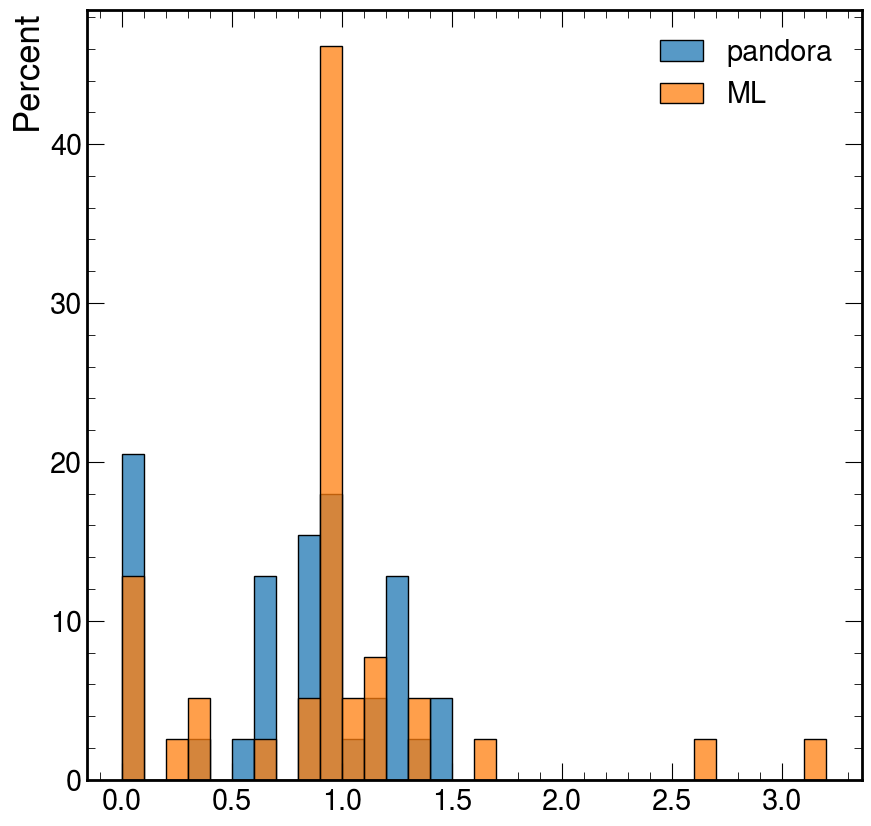

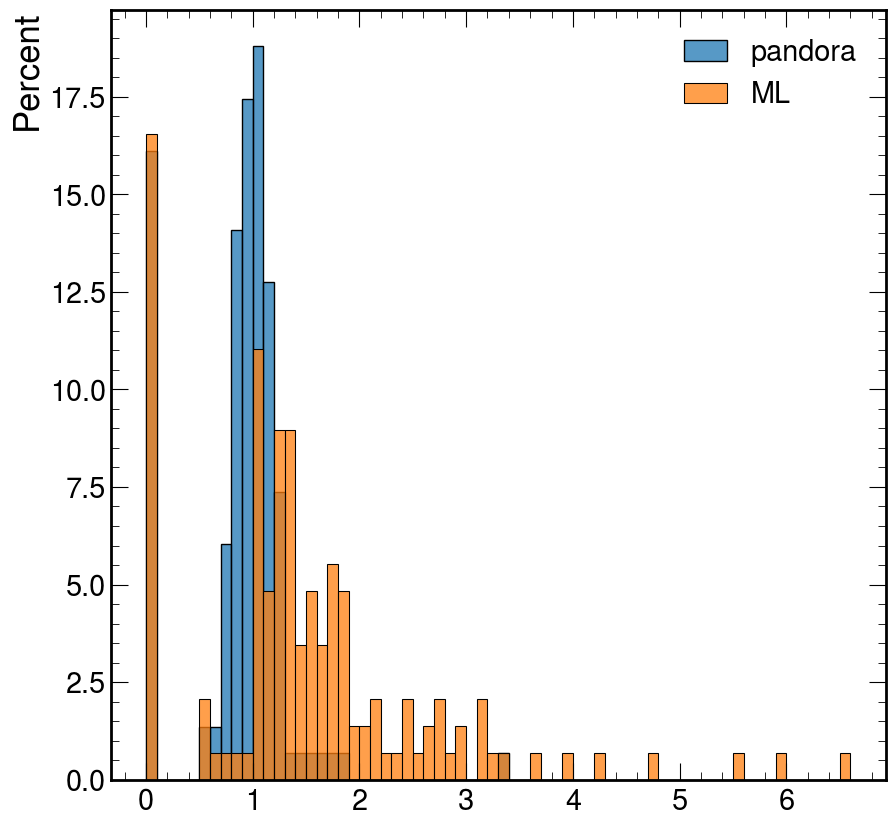

In [310]:
import seaborn as sns
plt.figure()
sns.histplot((sd_hgb1[sd_hgb1.pid==211].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==211].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora")
sns.histplot((sd_hgb[sd_hgb.pid==211].calibrated_E.values)/(sd_hgb[sd_hgb.pid==211].true_showers_E.values), stat="percent", binwidth=0.1, label="ML")
plt.legend()

import seaborn as sns
plt.figure()
sns.histplot((sd_hgb1[sd_hgb1.pid==22].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==22].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora")
sns.histplot((sd_hgb[sd_hgb.pid==22].calibrated_E.values)/(sd_hgb[sd_hgb.pid==22].true_showers_E.values), stat="percent", binwidth=0.1, label="ML")
plt.legend()

In [273]:
# from src.utils.inference.per_particle_metrics import create_eff_dic_pandora, create_eff_dic
# photons_dic = create_eff_dic_pandora(sd_hgb1, 211)
# photons_dic = create_eff_dic(photons_dic, sd_hgb, 211, var_i="a")
# plt.plot(photons_dic["eff_p"], "r")
# plt.plot(photons_dic["eff_a"])

In [274]:
df=sd_hgb
pandora = False
from torch_scatter import scatter_sum, scatter_mean

In [275]:
true_e = torch.Tensor(df.true_showers_E.values)
mask_nan_true = np.isnan(df.true_showers_E.values)
true_e[mask_nan_true] = 0
batch_idx = df.number_batch

pred_E = df.calibrated_E.values
nan_mask = np.isnan(df.calibrated_E.values)
print(np.sum(nan_mask))
pred_E[nan_mask] = 0
pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
pred_vect = torch.tensor(
    np.array(df.pred_pos_matched.values.tolist()) 
)
pred_vect[nan_mask] = 0
true_vect = torch.tensor(
    np.array(df.true_pos.values.tolist())
)
true_vect[mask_nan_true] = 0

batch_idx = torch.tensor(batch_idx.values).long()
pred_E = torch.tensor(pred_E)

true_jet_vect = scatter_sum(true_vect, batch_idx, dim=0)
pred_jet_vect = scatter_sum(pred_vect, batch_idx, dim=0)
true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)
true_jet_p = torch.norm(true_jet_vect, dim=1)  # This is actually momentum resolution
pred_jet_p = torch.norm(pred_jet_vect, dim=1)

mass_true = torch.sqrt(torch.abs(true_E_jet**2 - true_jet_p**2))
mass_pred = torch.sqrt(torch.abs(pred_E_jet**2 - pred_jet_p**2))

mass_over_true = mass_pred / mass_true

66


/tmp/mgarciam/ipykernel_3612701/3468593118.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/mgarciam/ipykernel_3612701/3468593118.py:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [276]:
df=sd_hgb1
pandora = True
from torch_scatter import scatter_sum, scatter_mean
true_e = torch.Tensor(df.true_showers_E.values)
mask_nan_true = np.isnan(df.true_showers_E.values)
true_e[mask_nan_true] = 0
batch_idx = df.number_batch
if pandora:
    pred_E = df.pandora_calibrated_pfo.values
    nan_mask = np.isnan(df.pandora_calibrated_pfo.values)
    pred_E[nan_mask] = 0
    pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
    pred_vect = torch.tensor(np.array(df.pandora_calibrated_pos.values.tolist()))
    pred_vect[nan_mask] = 0
    true_vect = torch.tensor(np.array(df.true_pos.values.tolist()))
    true_vect[mask_nan_true] = 0
else:
    pred_E = df.calibrated_E.values
    nan_mask = np.isnan(df.calibrated_E.values)
    print(np.sum(nan_mask))
    pred_E[nan_mask] = 0
    pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
    pred_vect = torch.tensor(
        np.array(df.pred_pos_matched.values.tolist()) 
    )
    pred_vect[nan_mask] = 0
    true_vect = torch.tensor(
        np.array(df.true_pos.values.tolist())
    )
    true_vect[mask_nan_true] = 0

batch_idx = torch.tensor(batch_idx.values).long()
pred_E = torch.tensor(pred_E)

true_jet_vect = scatter_sum(true_vect, batch_idx, dim=0)
pred_jet_vect = scatter_sum(pred_vect, batch_idx, dim=0)
true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)
true_jet_p = torch.norm(true_jet_vect, dim=1)  # This is actually momentum resolution
pred_jet_p = torch.norm(pred_jet_vect, dim=1)

mass_true = torch.sqrt(torch.abs(true_E_jet**2 - true_jet_p**2))
mass_pred_p = torch.sqrt(torch.abs(pred_E_jet**2 - pred_jet_p**2))

mass_over_true_p = mass_pred_p / mass_true

/tmp/mgarciam/ipykernel_3612701/2123600774.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/mgarciam/ipykernel_3612701/2123600774.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [277]:
def get_decay_type(sd_hgb1):
    batch_number = sd_hgb1.number_batch.values
    decay_type_list = []
    for batch_id in range(0, int(np.max(batch_number)) + 1):
        decay_type = determine_decay_type(sd_hgb1, batch_id)
        decay_type_list.append(decay_type)
    return torch.cat(decay_type_list)
def determine_decay_type(sd_hgb1, i):
    pid_values = np.abs(sd_hgb1[sd_hgb1.number_batch == i].pid.values)
    if len(pid_values) == 2:
        decay_type = 0
        charged = np.prod(pid_values == [211.0, 211])
    elif len(pid_values) == 4:
        decay_type = 1
        neutral = np.prod(pid_values == [22.0, 22.0, 22.0, 22.0])
    else:
        decay_type = 2

    return torch.Tensor([decay_type])


In [279]:

batch_number = sd_hgb.number_batch.values
p_zero = []
for batch_id in range(0, int(np.max(batch_number)) + 1):
    p_values = sd_hgb[sd_hgb.number_batch == batch_id].pred_pos_matched.values
    p_values1 = [np.sum(l) for l in p_values]
    sum_values = torch.sum(torch.Tensor(p_values1) == 0)>0   
    p_zero.append(torch.Tensor([sum_values]).to(bool).view(-1))

In [282]:
mask_easy_decays = (decay_type==0)*(~torch.cat(p_zero, dim=0))

In [280]:
decay_type = get_decay_type(sd_hgb1)

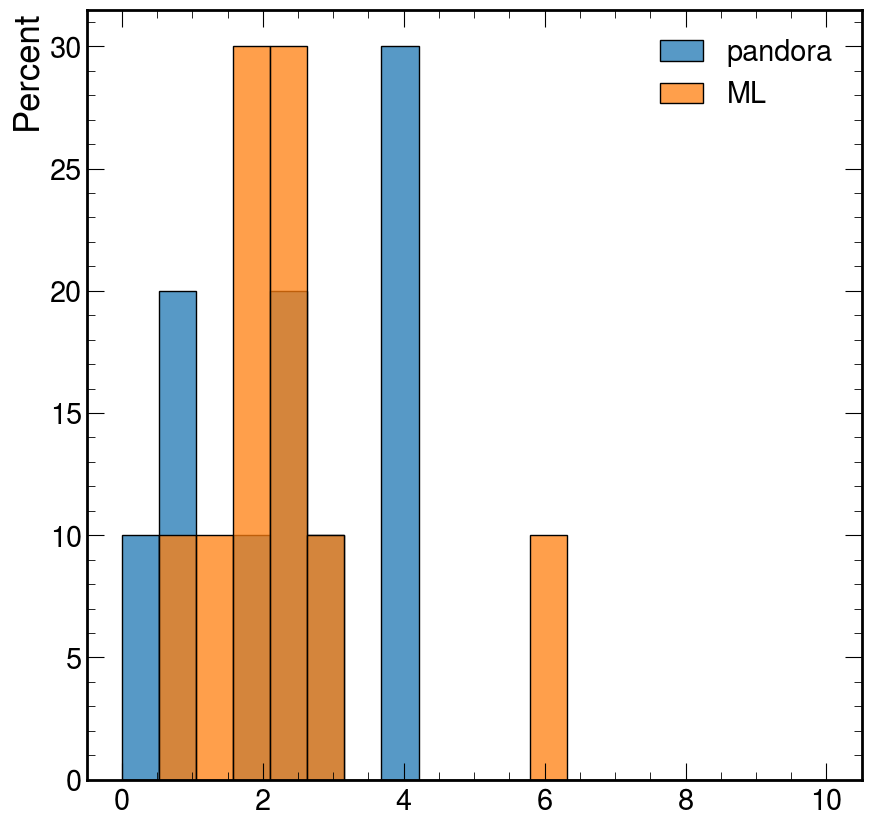

In [308]:
plt.plot()
bins = np.linspace(0,10, 20)
sns.histplot(mass_pred_p[mask_easy_decays]/mass_true[mask_easy_decays], stat="percent", bins=bins,label="pandora")
sns.histplot(mass_pred[mask_easy_decays]/mass_true[mask_easy_decays], stat="percent", bins=bins, label="ML")
# plt.xlim([0,5])
plt.legend()

In [301]:
mask_easy_decays = (decay_type==0)*(~torch.cat(p_zero, dim=0))
print(mass_pred_p[mask_easy_decays])
print(mass_pred[mask_easy_decays])
print(mass_true[mask_easy_decays])


tensor([1.2776, 0.4844, 1.4500, 2.0070, 0.0734, 1.8537, 0.5027, 0.8391, 1.9077,
        1.1167], dtype=torch.float64)
tensor([0.6379, 0.4858, 1.1436, 1.3905, 3.1030, 0.8762, 0.9526, 1.1481, 1.0062,
        1.2829], dtype=torch.float64)
tensor([0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977,
        0.4977], dtype=torch.float64)


In [285]:
mask_easy_decays.numpy().nonzero()

(array([ 0,  1, 24, 26, 29, 32, 39, 46, 67, 75]),)

In [302]:
id =39
sd_ML = sd_hgb[sd_hgb.number_batch ==id]
sd_ML

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,pred_pos_matched,true_pos
0,1.309336,0.753389,0.753389,0.753389,-211.0,1.672544,1.260076,5.0,39.0,"[1.1812525987625122, -0.11447528749704361, -0....","[1.1811110973358154, -0.11231295019388199, -0...."
1,5.441290,3.136867,3.136867,3.136867,211.0,1.704860,5.347919,5.0,39.0,"[5.070955276489258, 0.08493919670581818, -1.80...","[5.12466287612915, 0.08133536577224731, -1.821..."


In [298]:
sd_pandora = sd_hgb1[sd_hgb1.number_batch == id]
sd_pandora

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pid,step,number_batch,true_pos
0,15.622553,12.456781,30.442053,11.861981,35.432526,35.432526,"[-33.643558502197266, -8.210875511169434, 7.49...",-211.0,3.0,29.0,"[-14.94270133972168, -3.137948513031006, 3.303..."
1,14.786953,19.141750,NaN,NaN,NaN,0.000000,"[nan, nan, nan]",211.0,3.0,29.0,"[-14.095845222473145, -3.3355069160461426, 2.9..."


In [299]:
print("ML E", np.nansum(sd_ML.calibrated_E))
print("ML vector", np.nansum([sd_ML.pred_pos_matched.values[i] for i in range(0,len(sd_ML.pred_pos_matched.values))],axis=0))
a = np.nansum(sd_ML.calibrated_E)
b = np.nansum([sd_ML.pred_pos_matched.values[i] for i in range(0,len(sd_ML.pred_pos_matched.values))],axis=0)
print("ML mass", torch.sqrt(torch.abs(a**2 - torch.norm(torch.Tensor(b))**2)))
print("ML p", torch.norm(torch.Tensor(b)))
print("_________________________")
# reco mass 
print("true E",np.sum(sd_pandora.true_showers_E))
print("true vector",np.sum([sd_pandora.true_pos.values[i] for i in range(0,len(sd_pandora.true_pos.values))],axis=0))
a = np.sum(sd_pandora.true_showers_E)
b = np.sum([sd_pandora.true_pos.values[i] for i in range(0,len(sd_pandora.true_pos.values))],axis=0)
print("true mass", torch.sqrt(a**2 - torch.norm(torch.Tensor(b))**2))
print("true p", torch.norm(torch.Tensor(b)))
print("_________________________")
print("pandora E",np.nansum(sd_pandora.pandora_calibrated_pfo))
print("pandora v",np.nansum([sd_pandora.pandora_calibrated_pos.values[i] for i in range(0,len(sd_pandora.pandora_calibrated_pos.values))],axis=0))
a = np.nansum(sd_pandora.pandora_calibrated_pfo)
b = np.nansum([sd_pandora.pandora_calibrated_pos.values[i] for i in range(0,len(sd_pandora.pandora_calibrated_pos.values))],axis=0)
print("pandora mass", torch.sqrt(a**2 - torch.norm(torch.Tensor(b))**2))
print("pandora p", torch.norm(torch.Tensor(b)))

ML E 30.321049
ML vector [-29.10814953  -6.49283862   6.28913307]
ML mass tensor(3.1030)
ML p tensor(30.4794)
_________________________
true E 30.409506
true vector [-29.03854656  -6.47345543   6.27276134]
true mass tensor(0.4976)
true p tensor(30.4054)
_________________________
pandora E 35.432526
pandora v [-33.6435585   -8.21087551   7.49339533]
pandora mass tensor(0.0733)
pandora p tensor(35.4324)


In [300]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
fig = go.Figure()
scale = (
    1.0  
)
color_list = px.colors.qualitative.Light24
colors = ["black", "red", "blue", "green", "purple"]
colors1 = ["green", "green", "green", "green"]
for i in range(0,len(sd_pandora)):
    v = torch.Tensor(sd_pandora.pandora_calibrated_pos.values[i])
    # v = v/torch.norm(v)
    vt = torch.Tensor(sd_pandora.true_pos.values[i])
    # vt = vt/torch.norm(vt)
    plot_single_arrow(
        fig,
        v,
        line=dict(color=colors1[i], width=4, dash="dash"),
        color=colors[i]
    ) 
    plot_single_arrow(
        fig,
        vt,
        line=dict(color=colors[i], width=0.4),
        color=colors[i]
    ) 
for i in range(0,len(sd_ML)): 
    vt1 = torch.Tensor(sd_ML.pred_pos_matched.values[i])
    # vt1 = vt1/torch.norm(vt1)
    plot_single_arrow(
        fig,
        vt1,
        line=dict(color=colors[i], width=6, dash="dot"),
        color=colors[i]
    ) 
fig.show()

In [37]:
def plot_single_arrow(fig, vec, hovertext="", init_pt=[0, 0, 0], line = None, color=None):
    # init_pt: initial point of the vector
    fig.add_trace(
        go.Scatter3d(
            x=[init_pt[0], vec[0] + init_pt[0]],
            y=[init_pt[1], init_pt[1] + vec[1]],
            z=[init_pt[2], init_pt[2] + vec[2]],
            mode="lines",
            line=line,
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=[vec[0] + init_pt[0]],
            y=[vec[1] + init_pt[1]],
            z=[vec[2] + init_pt[2]],
            mode="markers",
            marker=dict(size=4, color=color),
            hovertext=hovertext,
        )
    )

In [176]:
def determibe_decay_type(sd_hgb1, i):
    pid_values = np.abs(sd_hgb1[sd_hgb1.number_batch==i].pid.values)
    if len(pid_values) ==2:
        decay_type = 0
        charged = np.prod(pid_values == [211.,211])
    elif len(pid_values) ==4:
        decay_type = 1
        neutral = np.prod(pid_values == [22., 22., 22., 22.])
    else:
        decay_type = 2
        
    return decay_type
    
p_v_true = sd_hgb1.true_pos.values
E_true = sd_hgb1.true_showers_E.values
p_v_pandora = sd_hgb1.pandora_calibrated_pos.values
E_pandora = sd_hgb1.pandora_calibrated_pfo.values
batch_number = sd_hgb1.number_batch.values
data = []
for batch_id in range(0, int(np.max(batch_number))): 
    mask = batch_number == batch_id
    if np.sum(mask)>0:
        energy_ks = np.nansum(E_true[mask])
        p_v_true_ = [p_v_true[mask][i] for i in range(0,len(p_v_true[mask]))]
        p_v_true_ = np.array(p_v_true_)
        pxj= np.nansum(p_v_true_[:,0])
        pyj= np.nansum(p_v_true_[:,1])
        pzj= np.nansum(p_v_true_[:,2])
        mj = (np.abs(energy_ks**2 - (pxj**2 + pyj**2 + pzj**2))) ** (
        1 / 2
        )

        energy_ks_p = np.nansum(E_pandora[mask])
        p_v_p = [p_v_pandora[mask][i] for i in range(0,len(p_v_pandora[mask]))]
        p_v_p = np.array(p_v_p)
        pxj_p= np.nansum(p_v_p[:,0])
        pyj_p= np.nansum(p_v_p[:,1])
        pzj_p= np.nansum(p_v_p[:,2])
        mj_p = (np.abs(energy_ks_p**2 - (pxj_p**2 + pyj_p**2 + pzj_p**2))) ** (
        1 / 2
        )
        decay_type = determibe_decay_type(sd_hgb1, batch_id)
        if mj>0:
            if mj_p>0:
                data.append([mj, mj_p, mj_p/mj, decay_type, batch_id])
            else:
                data.append([mj, -1, -1, decay_type, batch_id])

df = pd.DataFrame(data, columns=['Mass_true', 'Mass_pandora', 'P_T', 'Type', 'number_batch'])




(0.0, 10.0)

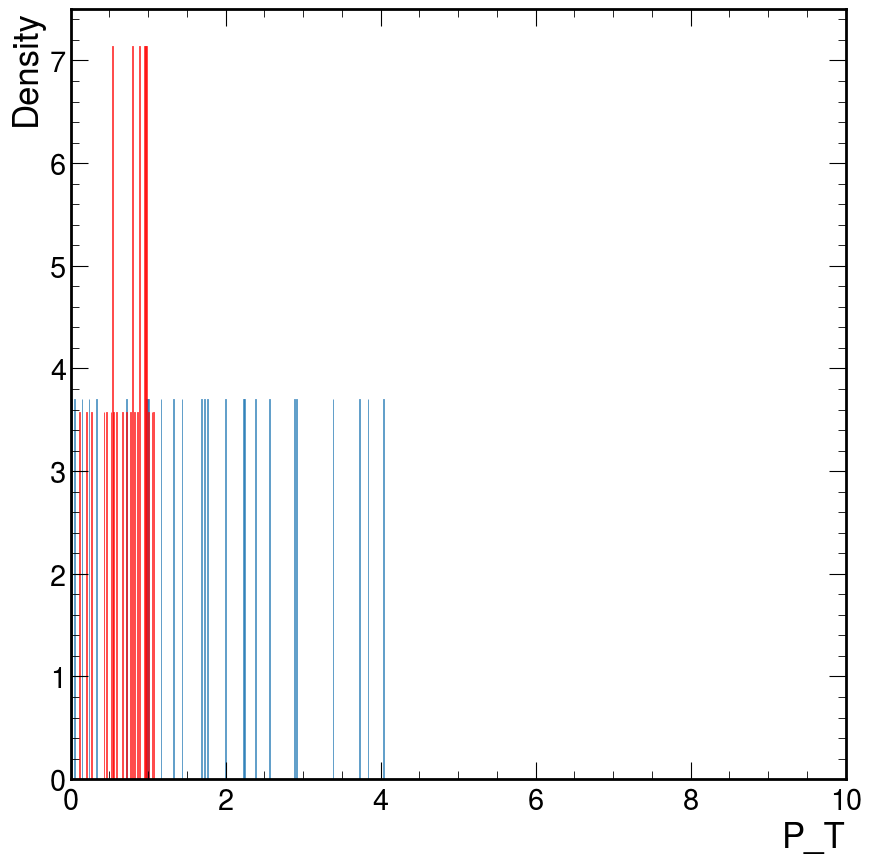

In [177]:
## plot the mass distirbutions 
import seaborn as sns 
plt.figure()
sns.histplot(df.P_T[df["Type"]==0], binwidth = 0.01, stat="density",  fill=False)
sns.histplot(df.P_T[df["Type"]==1], binwidth = 0.01, stat="density", color="r", fill=False)
# sns.histplot(df.P_T[df["Type"]==2], binwidth = 0.01, stat="density", color="k", fill=False)
plt.xlim([0,10])

# Find events that are badly reconstructed

In [178]:
df[df.P_T<0.1]

,Mass_true,Mass_pandora,P_T,Type,number_batch
7,0.497644,0.023410,0.047042,0,7
17,0.497751,0.026417,0.053073,2,17
18,0.139569,0.001826,0.013081,2,18
30,0.139570,0.000880,0.006306,2,30
53,0.139570,0.000061,0.000441,2,53
66,0.893684,0.001567,0.001754,2,66
81,0.497665,0.005476,0.011003,0,81


In [190]:
example = sd_hgb1[sd_hgb1.number_batch==81]
example
i = 81
pid_values = np.abs(sd_hgb1[sd_hgb1.number_batch==i].pid.values)
print(len(pid_values))
determibe_decay_type(sd_hgb1, 81)


2


0

In [191]:
example

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pid,step,number_batch,true_pos
0,10.192455,9.381804,8.770212,8.272466,9.184054,9.184054,"[0.9084263443946838, 9.020967483520508, 1.4641...",-211.0,11.0,81.0,"[0.9512829184532166, 9.993203163146973, 1.7600..."
1,1.964577,1.563850,NaN,NaN,NaN,NaN,"[nan, nan, nan]",211.0,11.0,81.0,"[0.07438014447689056, 1.942126989364624, 0.250..."


In [180]:
mask = batch_number == 81
energy_ks = np.nansum(E_true[mask])
p_v_true_ = [p_v_true[mask][i] for i in range(0,len(p_v_true[mask]))]
p_v_true_ = np.array(p_v_true_)
pxj= np.nansum(p_v_true_[:,0])
pyj= np.nansum(p_v_true_[:,1])
pzj= np.nansum(p_v_true_[:,2])
mj = (np.abs(energy_ks**2 - (pxj**2 + pyj**2 + pzj**2))) ** (
1 / 2
)
print(mj, energy_ks**2, (pxj**2 + pyj**2 + pzj**2), np.abs(energy_ks**2 - (pxj**2 + pyj**2 + pzj**2)))
energy_ks_p = np.nansum(E_pandora[mask])
p_v_p = [p_v_pandora[mask][i] for i in range(0,len(p_v_pandora[mask]))]
p_v_p = np.array(p_v_p)
pxj_p= np.nansum(p_v_p[:,0])
pyj_p= np.nansum(p_v_p[:,1])
pzj_p= np.nansum(p_v_p[:,2])
mj_p = (np.abs(energy_ks_p**2 - (pxj_p**2 + pyj_p**2 + pzj_p**2))) ** (
1 / 2
)
print(mj_p, energy_ks_p**2, (pxj_p**2 + pyj_p**2 + pzj_p**2), np.abs(energy_ks_p**2 - (pxj_p**2 + pyj_p**2 + pzj_p**2)))

0.49766525554344393 147.7934273636347 147.54575665705957 0.24767070657512136
0.005476023337427886 84.34685475735114 84.34688474418273 2.998683159205484e-05


In [164]:
import plotly
import plotly.graph_objs as go
import plotly.express as px

# arrows from 0,0,0 to df.true_pos and the hover text should be the true energy (df.true_showers_E)
fig = go.Figure()
scale = (
    1.0  # size of the direction vector, to make it easier to see it with the hits
)
# list of 20 random colors
# color_list = px.colors.qualitative.Plotly # this is only 10, not enough
color_list = px.colors.qualitative.Light24

def plot_single_arrow(fig, vec, hovertext="", init_pt=[0, 0, 0]):
    # init_pt: initial point of the vector
    fig.add_trace(
        go.Scatter3d(
            x=[init_pt[0], vec[0] + init_pt[0]],
            y=[init_pt[1], init_pt[1] + vec[1]],
            z=[init_pt[2], init_pt[2] + vec[2]],
            mode="lines",
            line=dict(color="black", width=1),
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=[vec[0] + init_pt[0]],
            y=[vec[1] + init_pt[1]],
            z=[vec[2] + init_pt[2]],
            mode="markers",
            marker=dict(size=4, color="black"),
            hovertext=hovertext,
        )
    )

plot_single_arrow(
    fig,
    example.pandora_calibrated_pos.values[0],
)  
plot_single_arrow(
    fig,
    example.true_pos.values[0],
) 
fig.show()

In [36]:
# sd_p = sd_hgb1[sd_hgb1.number_batch==0]
# sd = sd_hgb[sd_hgb.number_batch==0]

In [37]:
# N1 = 0
# N = 20
# sd_p[N1:N].pred_showers_E/sd_p[N1:N].reco_showers_E

In [38]:
# sd[N1:N].pred_showers_E/sd[N1:N].reco_showers_E

In [52]:
sd_hgb1.pandora_calibrated_pos

0     [nan, nan, nan]
1     [nan, nan, nan]
2     [nan, nan, nan]
3     [nan, nan, nan]
4     [nan, nan, nan]
           ...       
50    [nan, nan, nan]
51    [nan, nan, nan]
52    [nan, nan, nan]
53    [nan, nan, nan]
54    [nan, nan, nan]
Name: pandora_calibrated_pos, Length: 4281, dtype: object

In [41]:
reco_list = []
reco_list_pandora = []
for i in range(0,int(np.max(sd_hgb.number_batch))):
    mask = sd_hgb.number_batch==i
    event_E_total_reco = np.nansum(sd_hgb.calibrated_E[mask])
    event_ML_total_reco = np.nansum(sd_hgb.true_showers_E[mask])
    mask_p = sd_hgb1.number_batch==i
    event_E_total_reco_p = np.nansum(sd_hgb1.pandora_calibrated_pfo[mask_p])
    event_ML_total_reco_p = np.nansum(sd_hgb1.true_showers_E[mask_p])

    reco_list.append(event_E_total_reco/event_ML_total_reco)
    reco_list_pandora.append( event_E_total_reco_p/event_ML_total_reco_p)

(0.0, 2.0)

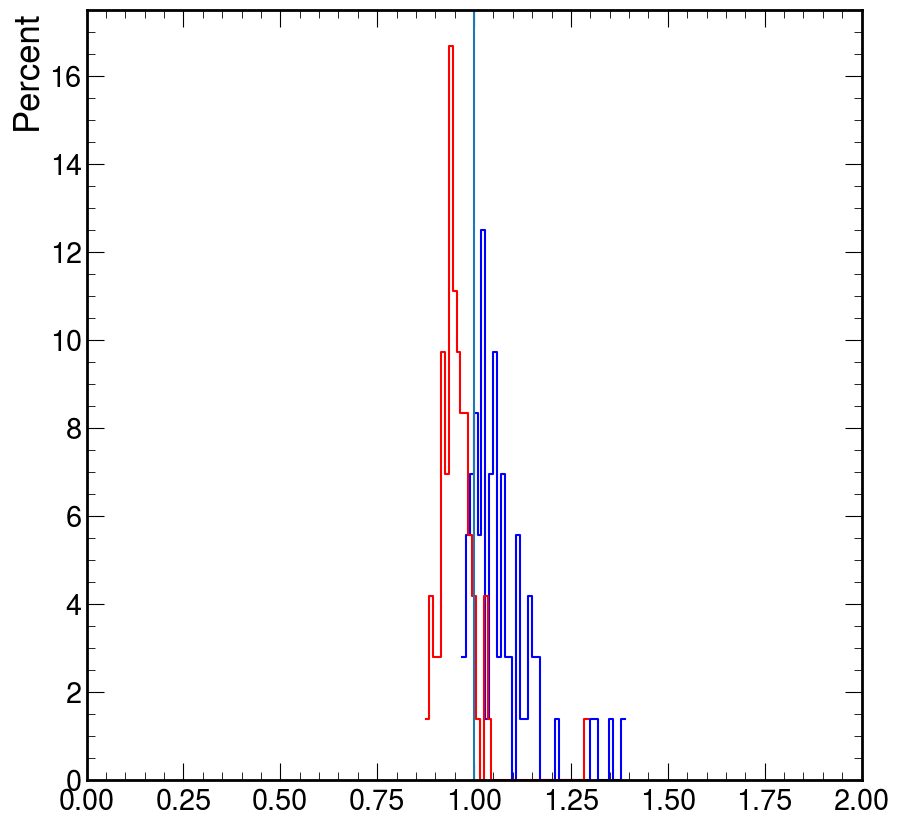

In [47]:
import seaborn as sns
fig = plt.figure()
sns.histplot(reco_list_pandora, binwidth=0.01, stat="percent", color="b", element="step", fill=False)
sns.histplot(reco_list, binwidth=0.01, stat="percent", color="r", element="step", fill=False)
plt.axvline(x=1)
plt.xlim([0,2])

In [8]:
total_showers = len(sd_hgb.true_showers_E) - np.sum(np.isnan(sd_hgb.true_showers_E))
matched_showers = len(matched_hgb)
matched_showers/total_showers
mask = matched_hgb["calibration_factor"]>0
db_test = matched_hgb[mask]
db_test_f = db_test[db_test["pid"]==22]


total_showers1 = len(sd_hgb.true_showers_E) - np.sum(np.isnan(sd_hgb.true_showers_E))
matched_showers1 = len(matched_hgbq1)
matched_showers1/total_showers1
db_test1 = matched_hgbq1
db_test_f1 = db_test1[db_test1["pid"]==22]
print(len(db_test_f),len(db_test_f1))


760 697


In [90]:
from src.utils.inference.inference_metrics import get_sigma_gaussian
def calculate_response(matched, pandora, log_scale=False, tracks=False):
    if log_scale:
        bins = np.exp(np.arange(np.log(0.1), np.log(80), 0.3))
    else:
        bins = np.arange(0, 51, 6)
    binning = 1e-4
    if pandora:
        bins_per_binned_E = np.arange(0.5, 1.5, binning)
    else:
        bins_per_binned_E = np.arange(0.5, 1.5, binning)
    mean = []
    variance_om = []
    mean_baseline = []
    variance_om_baseline = []
    mean_true_rec = []
    variance_om_true_rec = []
    energy_resolutions = []
    energy_resolutions_reco = []

   
    binning = 1e-3
    if pandora:
        bins_per_binned_E = np.arange(0, 2, binning)
    else:
        bins_per_binned_E = np.arange(0, 2, binning)
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = matched["true_showers_E"] <= bin_i1
        mask_below = matched["true_showers_E"] > bin_i
        mask_check = matched["pred_showers_E"] > 0
        mask = mask_below * mask_above * mask_check
        true_e = matched.true_showers_E[mask]
        true_rec = matched.reco_showers_E[mask]
        if pandora:
            if tracks:
                pred_e = matched.pandora_calibrated_pfo[mask]
            else:
                pred_e = matched.pandora_calibrated_E[mask]
        else:
            pred_e = matched.calibrated_E[mask]
        pred_e_nocor = matched.pred_showers_E[mask]
        if np.sum(mask) > 0:  # if the bin is not empty
            e_over_true = pred_e / true_e
            e_over_reco = true_rec / true_e
            e_over_reco_ML = pred_e_nocor / true_e
            # mean_predtotrue, var_predtotrue = obtain_MPV_and_68(
            #     e_over_true, bins_per_binned_E
            # )

            mean_predtotrue, var_predtotrue = get_sigma_gaussian(
                e_over_true, bins_per_binned_E
            )

            mean_reco_true, var_reco_true = get_sigma_gaussian(
                e_over_reco, bins_per_binned_E
            )

            mean_reco_ML, var_reco_ML = get_sigma_gaussian(
                e_over_reco_ML, bins_per_binned_E
            )
            # mean_reco_true, var_reco_true = obtain_MPV_and_68(
            #     e_over_reco, bins_per_binned_E
            # )

            # mean_predtotrue = np.mean(e_over_true)
            # var_predtotrue = np.var(e_over_true) / mean_predtotrue
            mean_true_rec.append(mean_reco_ML)
            variance_om_true_rec.append(np.abs(var_reco_ML))
            mean_baseline.append(mean_reco_true)
            variance_om_baseline.append(np.abs(var_reco_true))
            mean.append(mean_predtotrue)
            variance_om.append(np.abs(var_predtotrue))
            energy_resolutions.append((bin_i1 + bin_i) / 2)
            energy_resolutions_reco.append((bin_i1 + bin_i) / 2)

    return (
        mean,
        variance_om,
        mean_true_rec,
        variance_om_true_rec,
        energy_resolutions,
        energy_resolutions_reco,
        mean_baseline,
        variance_om_baseline,
    )


In [91]:
(
    mean1,
    variance_om1,
    mean_true_rec1,
    variance_om_true_rec1,
    energy_resolutions1,
    energy_resolutions_reco1,
    mean_baseline1,
    variance_om_baseline1,
) =calculate_response(db_test_f, False, log_scale=False, tracks=True)

1.0986864406779653 0.09085585275913481
1.0168054393305472 0.038163732369298355
1.038404011461321 0.04649595783491161
1.0568787878787882 0.04755953833792366
1.017507407407408 0.0032688073525377263
1.0123666666666662 0.004138678518518482
1.0350443037974688 0.025689286011857635
1.0129756097560974 0.0017239811124330478
1.005634146341463 0.0021857015169541843
1.0659210526315788 0.07060192797784128
1.0234333333333343 0.0008954955555555719
1.0188500000000014 0.0017456608333333557
1.0446777777777752 0.02124752395061727
1.017033333333333 0.0014658488888888883
1.0084777777777774 0.002199710617283968
1.1185000000000036 0.08232542857143031
1.0045909090909086 0.000613809917355371
1.0032272727272717 0.0006266528925619862
1.1045333333333311 0.034823498888888055
1.0138999999999991 0.000996439999999992
1.0132333333333337 0.0009834622222222235
1.095125000000007 0.056445359375004174
1.0125624999999996 0.0005396835937499691
1.0121875000000002 0.0005350898437500197


In [82]:
(
    mean_p,
    variance_om_p,
    mean_true_rec_p,
    variance_om_true_rec_p,
    energy_resolutions_p,
    energy_resolutions_reco_p,
    mean_baseline,
    variance_om_baseline,
) = calculate_response(db_test_f1, True, False, tracks=True)
(
    mean,
    variance_om,
    mean_true_rec,
    variance_om_true_rec,
    energy_resolutions,
    energy_resolutions_reco,
    mean_baseline,
    variance_om_baseline,
) = calculate_response(db_test_f, False, False, tracks=True)

1.0337313787638625 0.043825635845800584
1.016790519877681 0.028686487463644467
0.9940904173106648 0.017632878609872237
1.0160839416058385 0.0044117320049015295
1.017040145985401 0.0033731826948692006
0.9823613138686117 0.0029628201822150565
1.0183795180722897 0.005518467411815498
1.0128493975903616 0.0017045164755406924
0.9811746987951803 0.0005220508056321138
1.0299754098360638 0.004527396936307053
1.022844262295082 0.0009016355818328559
0.9824016393442621 0.00011995753829616844
1.0207083333333333 0.0011383732638888943
1.0175416666666663 0.0013864565972222256
0.9859375000000006 0.0009268710937500959
1.0044999999999993 0.0006255652173912949
1.004760869565217 0.0005877580340264667
0.9822391304347827 3.844990548204133e-06
1.013656250000001 0.0010555068359374903
1.0129999999999997 0.0010103124999999945
0.9831875 3.9648437500000875e-06
1.017166666666667 0.000583777777777778


/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1.015611111111111 0.0005554320987654024
0.9841111111111109 2.5709876543210474e-06
1.0986864406779653 0.09085585275913481
1.0168054393305472 0.038163732369298355
1.0282588652482256 0.01803265674764923
1.0568787878787882 0.04755953833792366
1.017507407407408 0.0032688073525377263
0.9948333333333335 0.0005026518518518775
1.0350443037974688 0.025689286011857635
1.0129756097560974 0.0017239811124330478
0.9929268292682923 0.0004042202558001381
1.0659210526315788 0.07060192797784128
1.0234333333333343 0.0008954955555555719
0.9954333333333336 0.00065742888888891
1.0446777777777752 0.02124752395061727
1.017033333333333 0.0014658488888888883
0.9913888888888889 0.000575787654320998
1.1185000000000036 0.08232542857143031
1.0045909090909086 0.000613809917355371
0.9986818181818182 1.233057851239737e-05
1.1045333333333311 0.034823498888888055
1.0138999999999991 0.000996439999999992
0.9992666666666669 2.445555555555634e-06
1.095125000000007 0.056445359375004174
1.0125624999999996 0.0005396835937499691

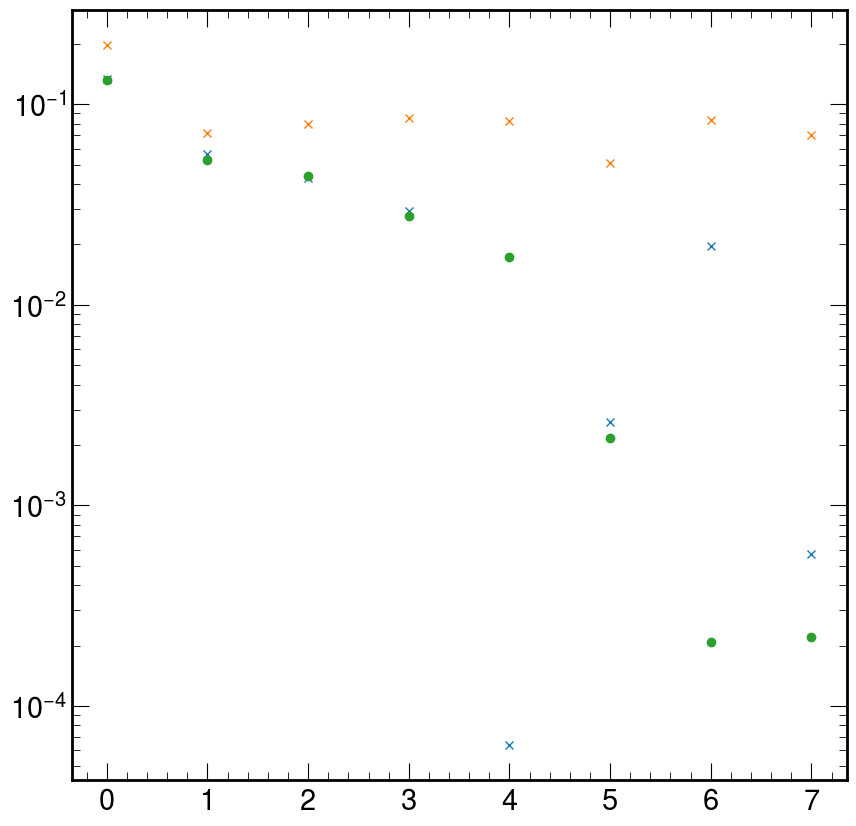

In [92]:
plt.figure()
plt.plot(variance_om_p,'x')
plt.plot(variance_om,'x')
plt.plot(variance_om_true_rec1,'o')
plt.yscale("log")

In [114]:
df1 = db_test_f[db_test_f.true_showers_E>2]
df1[0:10]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch
2,10.673800,10.467664,10.467658,10.467657,22.0,0.967844,10.131060,0.0,0.0
11,6.595091,7.288718,7.350991,7.151270,22.0,0.977451,7.185234,0.0,0.0
6,3.552042,3.855478,3.855478,3.855478,22.0,1.261427,4.863405,0.0,2.0
1,16.278809,16.637976,16.637976,16.637972,22.0,0.970276,16.143425,0.0,3.0
3,2.353110,2.460390,2.354351,2.350920,22.0,1.032206,2.430176,0.0,3.0
7,11.080539,11.600993,11.574243,11.574244,22.0,1.020641,11.813145,0.0,3.0
1,7.380130,8.438177,8.438177,8.438177,22.0,0.922198,7.781671,1.0,0.0
11,4.661159,4.405111,3.532816,3.499858,22.0,0.956793,3.380174,1.0,0.0
0,2.029570,2.254331,2.259664,2.254331,22.0,1.114840,2.519162,1.0,1.0
5,6.013392,6.620843,6.610911,6.610911,22.0,0.966622,6.390253,1.0,1.0


In [113]:
df2 = db_test_f1[db_test_f1.true_showers_E>2]
df2[0:10]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pid,step,number_batch
2,10.673800,10.467657,10.165531,10.165531,10.346188,10.346188,22.0,0.0,0.0
4,26.178064,27.273335,26.762985,26.762985,27.238468,27.238468,22.0,0.0,0.0
11,6.595091,7.288717,7.241804,7.075727,7.370484,7.370484,22.0,0.0,0.0
6,3.552042,3.855478,3.718906,3.718906,3.784995,3.784995,22.0,0.0,2.0
1,16.278809,16.637974,16.316826,16.316832,16.606821,16.606821,22.0,0.0,3.0
3,2.353110,2.460390,3.417842,2.365486,3.478576,3.478576,22.0,0.0,3.0
7,11.080539,11.600992,11.263609,11.263609,11.463797,11.463797,22.0,0.0,3.0
1,7.380130,8.438176,8.167585,8.167585,8.312737,8.312737,22.0,1.0,0.0
11,4.661159,4.405111,4.421892,3.941726,4.500471,4.500471,22.0,1.0,0.0
0,2.029570,2.254331,2.198401,2.198401,2.237468,2.237468,22.0,1.0,1.0


(0.0, 3.0)

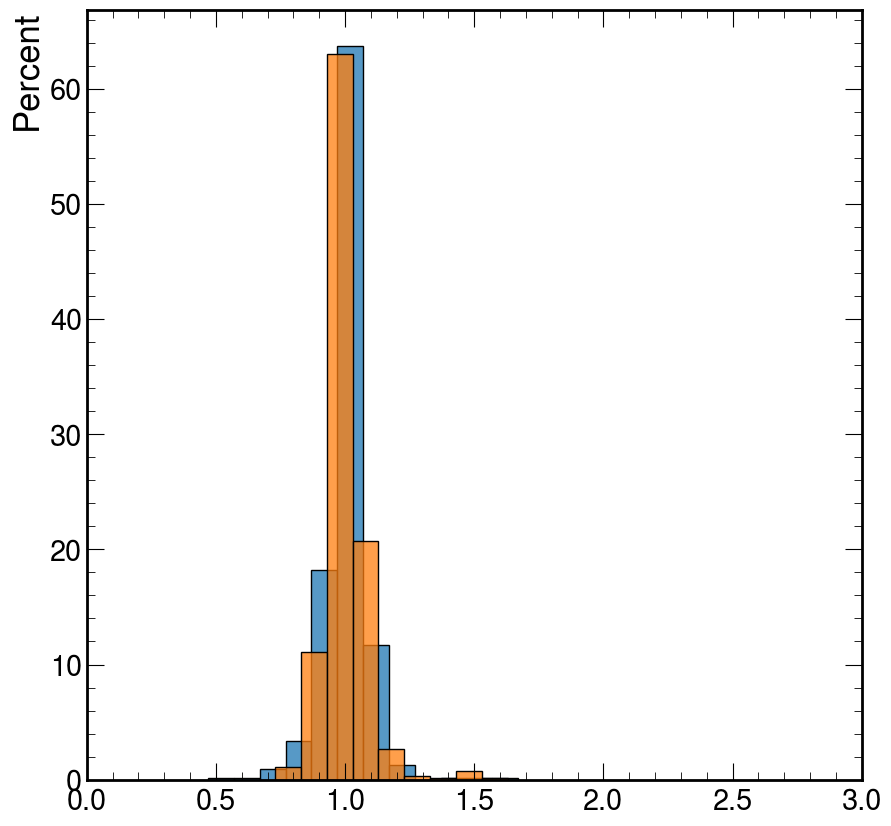

In [118]:
plt.figure()
sns.histplot(df1.pred_showers_E/df1.true_showers_E, stat = "percent", binwidth = 0.1)
sns.histplot(df2.pred_showers_E/df2.true_showers_E,stat = "percent", binwidth = 0.1)
plt.xlim([0,3])


In [71]:
bins = np.arange(0, 51, 6)
binning = 1e-3
pandora = False
tracks = True
matched = db_test_f
if pandora:
    bins_per_binned_E = np.arange(0, 2, binning)
else:
    bins_per_binned_E = np.arange(0, 2, binning)
i = 0 
bin_i = bins[i]
bin_i1 = bins[i + 1]
mask_above = matched["true_showers_E"] <= bin_i1
mask_below = matched["true_showers_E"] > bin_i
mask_check = matched["pred_showers_E"] > 0
mask = mask_below * mask_above * mask_check
true_e = matched.true_showers_E[mask]
true_rec = matched.reco_showers_E[mask]
if pandora:
    if tracks:
        pred_e = matched.pandora_calibrated_pfo[mask]
    else:
        pred_e = matched.pandora_calibrated_E[mask]
else:
    pred_e = matched.calibrated_E[mask]
pred_e_nocor = matched.pred_showers_E[mask]
if np.sum(mask) > 0:  # if the bin is not empty
    e_over_true = pred_e / true_e
    e_over_reco = true_rec / true_e
    e_over_reco_ML = pred_e_nocor / true_rec

matched = db_test_f1
if pandora:
    bins_per_binned_E = np.arange(0, 2, binning)
else:
    bins_per_binned_E = np.arange(0, 2, binning)
bin_i = bins[i]
bin_i1 = bins[i + 1]
mask_above = matched["true_showers_E"] <= bin_i1
mask_below = matched["true_showers_E"] > bin_i
mask_check = matched["pred_showers_E"] > 0
mask = mask_below * mask_above * mask_check
true_e = matched.true_showers_E[mask]
true_rec = matched.reco_showers_E[mask]
pred_e = matched.pandora_calibrated_pfo[mask]
    
pred_e_nocor = matched.pred_showers_E[mask]
if np.sum(mask) > 0:  # if the bin is not empty
    e_over_true1 = pred_e / true_e
    e_over_reco1 = true_rec / true_e
    e_over_reco_ML1 = pred_e_nocor / true_rec

In [80]:
from scipy.optimize import curve_fit
from scipy import asarray as ar, exp
hist, bin_edges = np.histogram(e_over_true1, bins=bins_per_binned_E, density=True)
# Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X, C, X_mean, sigma):
    return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))

n = len(hist)
x_hist = np.zeros((n), dtype=float)
for ii in range(n):
    x_hist[ii] = (bin_edges[ii + 1] + bin_edges[ii]) / 2

y_hist = hist

mean = sum(x_hist * y_hist) / sum(y_hist)
sigma = sum(y_hist * (x_hist - mean) ** 2) / sum(y_hist)

param_optimised, param_covariance_matrix = curve_fit(
    gaus, x_hist, y_hist, p0=[max(y_hist), mean, sigma], maxfev=10000
)
param_optimised[1], param_optimised[2] / param_optimised[1]

/tmp/mgarciam/ipykernel_2174330/1960675749.py:6: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))


(0.9908435951998111, 0.13411435988246742)

In [ ]:
1.0259126907513694, 0.19836546583500628

(0.0, 3.0)

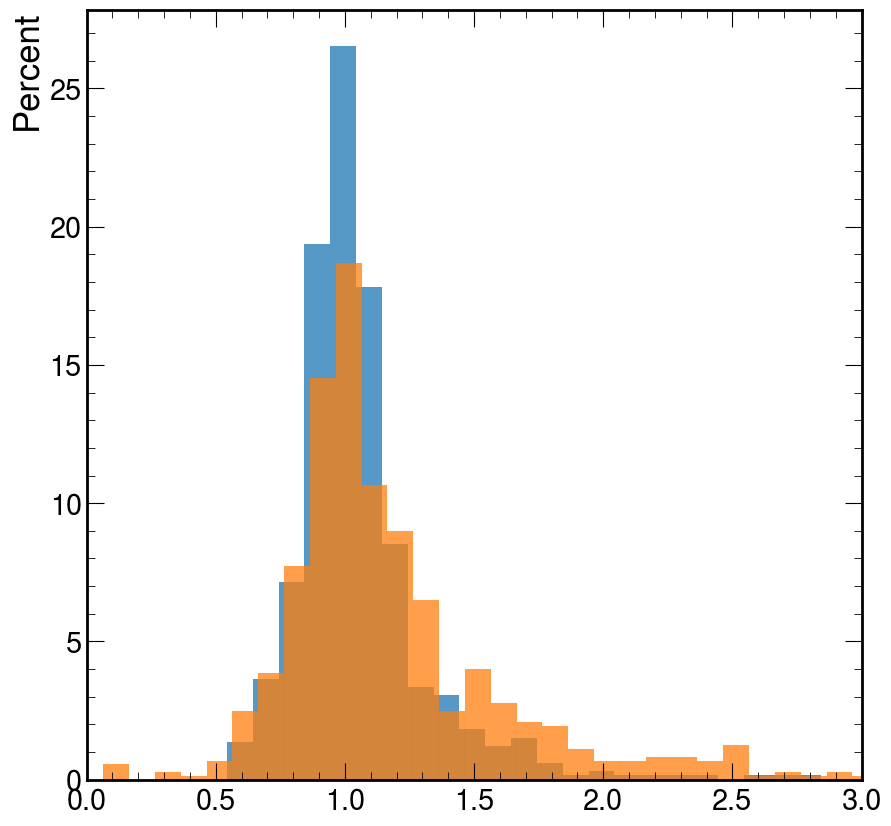

In [81]:
import seaborn as sns
plt.figure()
sns.histplot(e_over_true1, stat="percent", binwidth = 0.1)
sns.histplot(e_over_true, stat="percent", binwidth = 0.1)
plt.xlim([0,3])


In [62]:
def get_mask_id(id, pids_pandora):
    mask_id = np.full((len(pids_pandora)), False, dtype=bool)
    for i in id:
        mask_i = pids_pandora == i
        mask_id = mask_id + mask_i
    mask_id = mask_id.astype(bool)
    return mask_id
id = [22]
pids_pandora = np.abs(matched_hgb["pid"].values)
mask_id = get_mask_id(id, pids_pandora)
df_id_pandora = matched_hgb[mask_id]
df_id_pandora

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pid,step,number_batch
2,10.673800,10.467664,10.165531,10.165531,10.346188,10.346188,22.0,0.0,0.0
4,26.178064,27.273340,26.762995,26.762995,27.238468,27.238468,22.0,0.0,0.0
7,1.097436,1.023763,0.981896,0.981896,0.999344,0.999344,22.0,0.0,0.0
11,6.595091,7.288718,7.241804,7.075727,7.370484,7.370484,22.0,0.0,0.0
8,0.798549,0.626237,0.586670,0.586670,0.597095,0.597095,22.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
10,8.694870,8.762220,8.567705,8.567705,8.719964,8.719964,22.0,106.0,1.0
11,2.647010,2.553064,2.216019,2.216019,2.255399,2.255399,22.0,106.0,1.0
0,36.234837,38.889568,38.258133,38.258129,38.937634,38.937634,22.0,106.0,2.0
1,20.727648,20.283783,19.804920,19.804920,20.156818,20.156818,22.0,106.0,2.0


In [75]:
mean = []
variance_om = []
energy_resolutions_reco= []
matched = df_id_pandora
binning = 1e-3
bins = np.arange(0, 51, 6)
bins_per_binned_E = np.arange(0, 2, binning)
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    mask_above = matched["true_showers_E"] <= bin_i1
    mask_below = matched["true_showers_E"] > bin_i
    mask_check = matched["pred_showers_E"] > 0
    mask = mask_below * mask_above * mask_check
    true_e = matched.reco_showers_E[mask]
    true_rec = matched.pred_showers_E[mask]
    if np.sum(mask) > 0:  # if the bin is not empty
        e_over_reco = true_rec / true_e
        _,mean_, resolution = get_sigma_gaussian(e_over_reco)
        mean.append(mean_)
        variance_om.append(np.abs(resolution))
        energy_resolutions_reco.append((bin_i1 + bin_i) / 2)
        if i == 1:
            break



/tmp/mgarciam/ipykernel_2399520/947852987.py:5: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return C*exp(-(X-X_mean)**2/(2*sigma**2))


In [71]:
len(e_over_reco)

137

/tmp/mgarciam/ipykernel_2399520/3546955002.py:4: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return C*exp(-(X-X_mean)**2/(2*sigma**2))


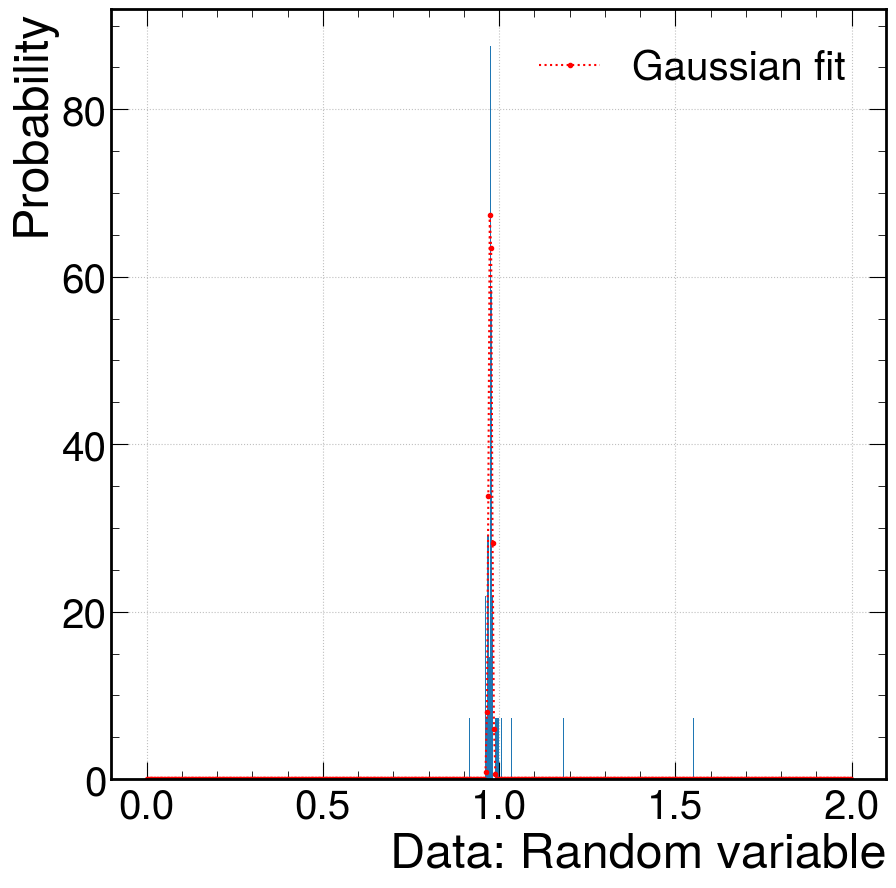

In [59]:
fig = plt.figure()
x_hist_2=np.linspace(np.min(x_hist),np.max(x_hist),500)
plt.plot(x_hist_2,gaus(x_hist_2,*param_optimised),'r.:',label='Gaussian fit')
plt.legend()

#Normalise the histogram values
weights = np.ones_like(e_over_reco) / len(e_over_reco)
plt.hist(e_over_reco,bins=bins_per_binned_E, density=True)

#setting the label,title and grid of the plot
plt.xlabel("Data: Random variable")
plt.ylabel("Probability")
plt.grid("on")
plt.show()

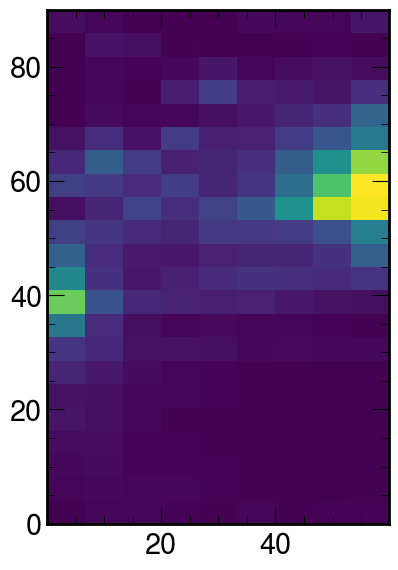

In [52]:
# sd_true_showers = sd_hgb[~np.isnan(sd_hgb.true_showers_E)]
# x = sd_true_showers.true_showers_E 
# y = sd_true_showers.reco_showers_E
# xedges = np.exp(np.arange(np.log(0.001), np.log(80), 0.5))
# yedges = np.arange(0,100,10)
# H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(131)
# plt.imshow((H+3)/np.sum(H), interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [51]:
A = (H+1)/np.sum(H)
1/(A[-1,:]

array([1.72950536e-03, 6.05326877e-04, 4.32376340e-05, 0.00000000e+00,
       0.00000000e+00, 1.12417848e-03, 7.78277413e-04, 8.21515047e-04,
       2.81044621e-03])

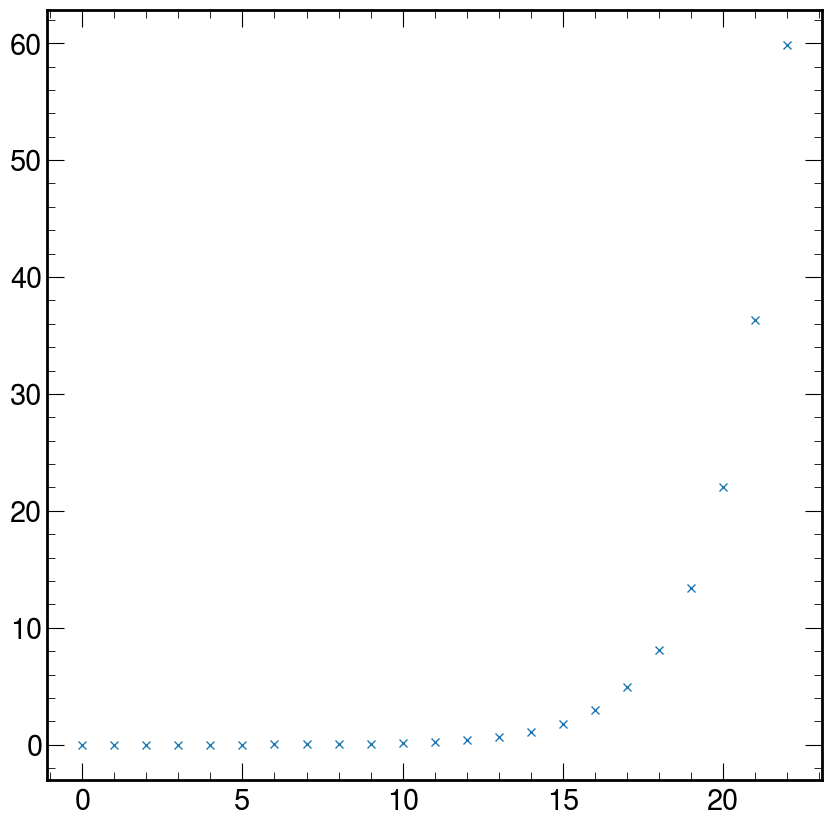

In [42]:
plt.plot(xedges,'x')

In [16]:
H.shape

(22, 9)

<Axes: ylabel='Percent'>

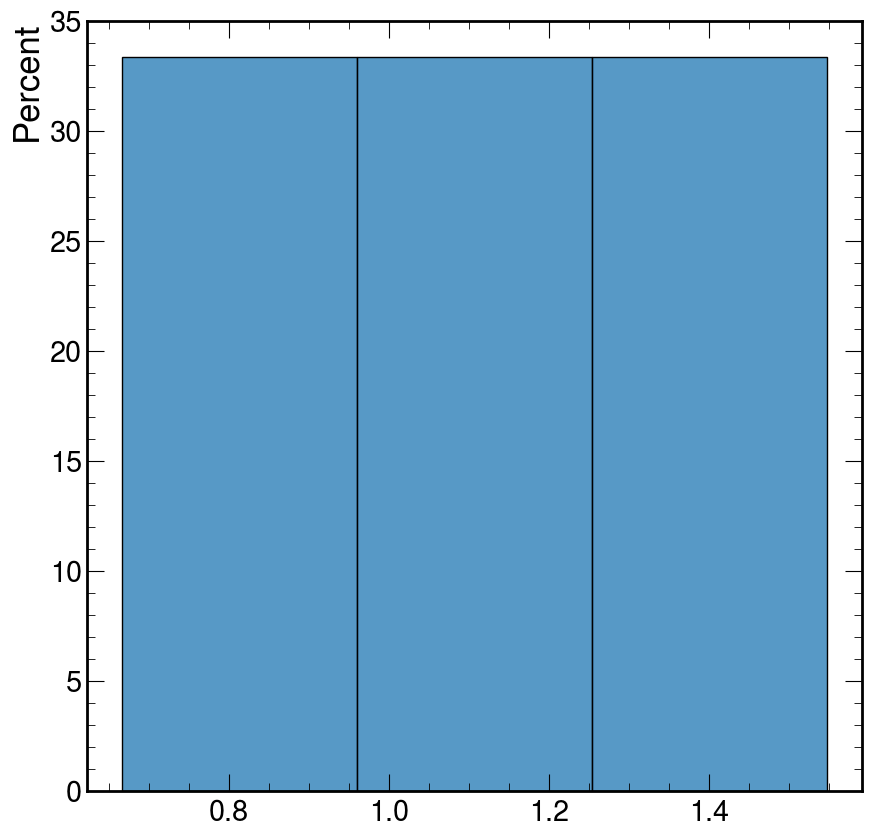

In [16]:
import seaborn as sns
sns.histplot(np.abs(sd_hgb["reco_showers_E"][mask]/sd_hgb["true_showers_E"][mask]), stat="percent")

In [14]:
mask =  ~np.isnan(sd_hgb["reco_showers_E"])
np.sum(~np.isnan(sd_hgb["pred_showers_E"][mask].values)) / len(
            sd_hgb["pred_showers_E"][mask].values
        )

0.987203302373581

<Axes: xlabel='true_showers_E', ylabel='Count'>

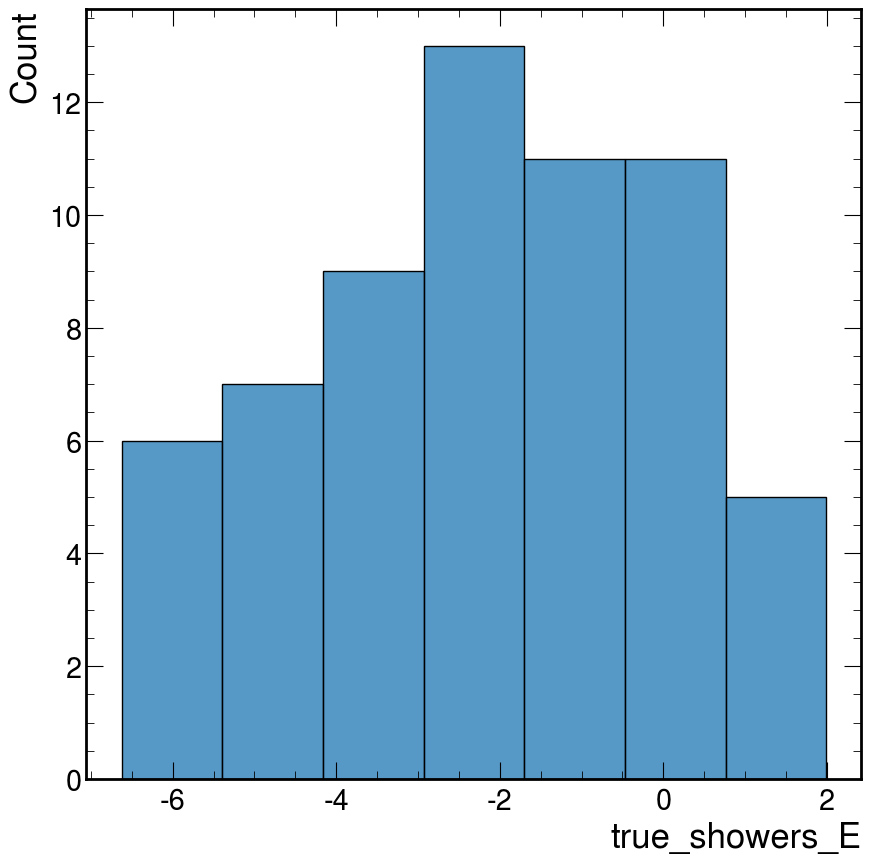

In [18]:
mask2 = np.isnan(sd_hgb["pred_showers_E"][mask].values)
import seaborn
sns.histplot(np.log(sd_hgb[mask][mask2]["true_showers_E"]))

count_events = 0
for i in range(0,len(sd_hgb)):
    ex = sd_hgb.iloc[i]
    if sd_hgb.iloc[0].name == 0:
        count_events = count_events+1
    if sd_hgb.iloc[i].true_showers_E>30 and np.isnan(sd_hgb.iloc[i].pred_showers_E) ==True:
        print(sd_hgb.iloc[i])
        break

In [52]:
27/8071

0.0033453103704621486

In [78]:
mask = sd_hgb["true_showers_E"]>26
#mask2 = np.isnan(sd_hgb[mask]["pred_showers_E"])
mask2 = sd_hgb[mask]["true_showers_E"]<28
np.sum(np.isnan(sd_hgb[mask][mask2]["pred_showers_E"]))

46

In [79]:
len(sd_hgb[mask][mask2])

242

In [75]:
(len(sd_hgb[mask][mask2])-13)/len(sd_hgb[mask][mask2])

0.6829268292682927

In [50]:
mask = sd_hgb["true_showers_E"]>29
mask2 = np.isnan(sd_hgb[mask]["pred_showers_E"])
sd_hgb[mask][mask2]

,reco_showers_E,true_showers_E,pred_showers_E,e_pred_and_truth
10,68.0,30.444792,NaN,NaN
9,42.0,30.438763,NaN,NaN
9,54.0,29.971210,NaN,NaN
2,72.0,29.526125,NaN,NaN
2,66.0,29.782215,NaN,NaN
9,46.0,30.434885,NaN,NaN
1,87.0,44.999981,NaN,NaN
9,66.0,30.224314,NaN,NaN
2,46.0,32.211159,NaN,NaN
9,52.0,30.387098,NaN,NaN


In [8]:
8071/1149814*100

0.7019396180599644

In [2]:
from src.utils.inference.pandas_helpers import open_hgcal, open_mlpf_dataframe
neutrals_only = True 
PATH_store = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/test_L/showers_df_evaluation/"
    
path_hgcal = PATH_store + "0_0_None_hdbscan.pt"
path_pandora = PATH_store + "0_0_None_pandora.pt"
# sd_1, matched_1 = open_mlpf_dataframe(path_hgcal, neutrals_only)
# sd_2, matched_2 = open_mlpf_dataframe(path_pandora, neutrals_only)

In [3]:
colors_list = ["#fde0dd", "#c994c7", "#dd1c77"]  # color list poster neurips
data = pd.read_pickle(path_hgcal)
sd = data
mask = (~np.isnan(sd["pred_showers_E"])) * (~np.isnan(sd["true_showers_E"]))
matched_ = sd[mask]
data_pandora = pd.read_pickle(path_pandora)
sd_pandora = data_pandora
mask_pandora = (~np.isnan(sd_pandora["pred_showers_E"])) * (~np.isnan(sd_pandora["true_showers_E"]))
matched_pandora = sd_pandora[mask_pandora]
# from src.utils.inference.per_particle_metrics import get_response_for_id_i
marker_size = 15
log_scale = True
# photons_dic = get_response_for_id_i([22], matched_pandora, matched_)
# electrons_dic = get_response_for_id_i([11], matched_pandora, matched_)

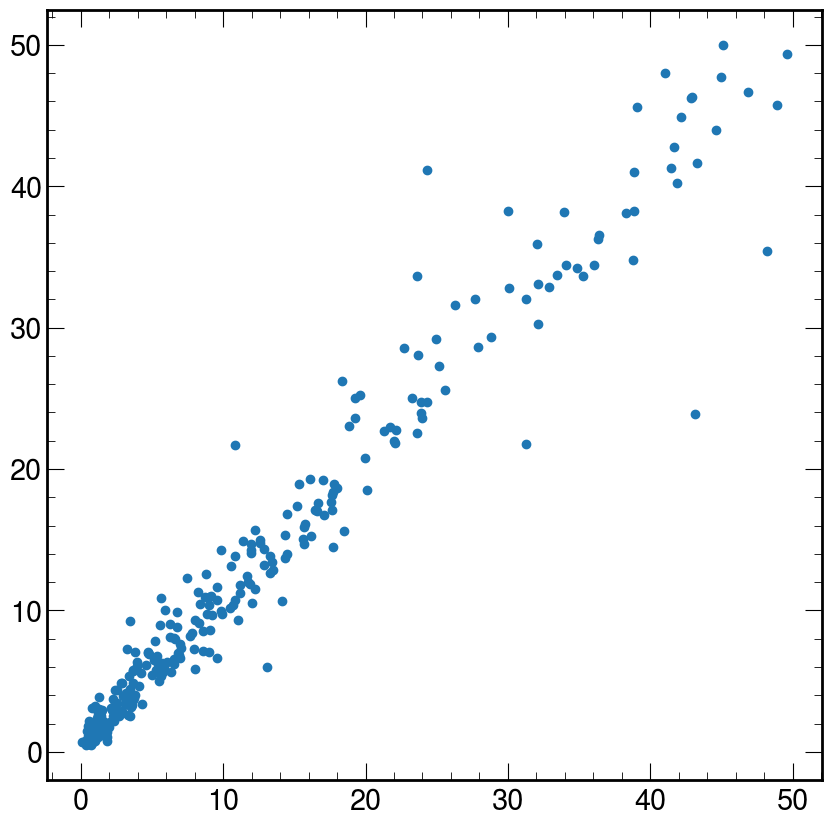

In [4]:
plt.plot(matched_pandora["pred_showers_E"],matched_pandora["true_showers_E"], 'o')

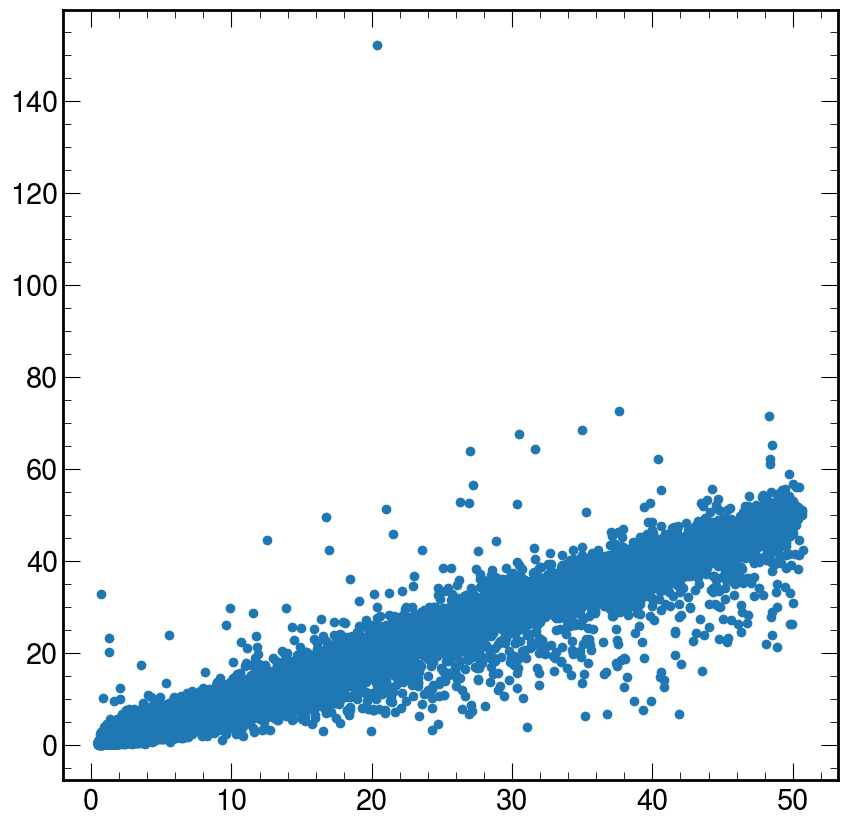

In [129]:
plt.plot(matched_pandora["true_showers_E"],matched_pandora["pandora_calibrated_pfo"], 'o')

In [117]:
sd = sd.reset_index(drop=True)
sd_pandora = sd_pandora.reset_index(drop=True)

In [118]:
number_of_showers = len(sd_pandora["number_batch"].values)
counter_i = 0
counter_total = 0
calibrated_list_pandora = []
reco_list_pandora = []

In [119]:
for i in range(0,500*10):
    sum_by = np.argmax(sd_pandora["number_batch"].values != counter_i)
    temp_sd = sd_pandora[0:sum_by]
    mask = (temp_sd["pred_showers_E"] > 0.6) * (
            np.isnan(temp_sd["true_showers_E"])
        ) + (~np.isnan(temp_sd["true_showers_E"]))
    temp_sd = temp_sd[mask]
    counter_total = counter_total + sum_by
    total_e_event = np.nansum(temp_sd["true_showers_E"].values)
    total_e_reco = np.nansum(temp_sd["reco_showers_E"].values)
    total_e_ML_cali = np.nansum(temp_sd["pandora_calibrated_pfo"].values)
    total_e_reco_ML = np.nansum(temp_sd["pred_showers_E"].values)
    calibrated_list_pandora.append(total_e_ML_cali / total_e_event)

    # print(total_e_ML_cali / total_e_event)
    if total_e_ML_cali / total_e_event>1.4:
        print("here")
        break 
    reco_list_pandora.append(total_e_reco_ML / total_e_reco)

    sd_pandora = sd_pandora.drop(np.arange(0, sum_by))
    counter_i = np.mod(counter_i + 1, 4)
    sd_pandora = sd_pandora.reset_index(drop=True)
    # print("2", number_of_showers, counter_total, number_of_showers - counter_total)


here


In [120]:
temp_sd

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pid,step,number_batch
0,8.455387,8.683648,7.504251,7.504251,7.637593,7.637593,130.0,430.0,1.0
1,5.701193,6.092900,5.957922,5.957922,6.063794,6.063794,22.0,430.0,1.0
2,13.497622,9.465176,8.707197,8.707197,11.183139,11.183139,2112.0,430.0,1.0
3,2.507385,2.034504,1.721214,1.674102,36.995144,36.995144,130.0,430.0,1.0
4,2.578079,2.790817,2.786784,2.786784,2.941849,2.941849,130.0,430.0,1.0
5,35.527355,35.684345,35.079075,35.079109,35.702625,35.702625,22.0,430.0,1.0
6,3.279593,3.749197,3.662058,3.654781,3.727134,3.727134,22.0,430.0,1.0
7,1.469823,0.523005,0.512081,0.512081,0.673180,0.673180,130.0,430.0,1.0


In [101]:
np.isnan(temp_sd["pid"].values[7])

True

In [64]:
pids = np.abs(sd["pid"].values)
mask_id = pids == 211
df_id = sd[mask_id]
bin_i = 0
bin_i1 = 2
mask_above = df_id.reco_showers_E.values <= bin_i1
mask_below = df_id.reco_showers_E.values > bin_i
mask = mask_below * mask_above
number_of_non_reconstructed_showers = np.sum(
    np.isnan(df_id.pred_showers_E.values)[mask]
)
total_showers = len(df_id.pred_showers_E.values[mask])

(total_showers - number_of_non_reconstructed_showers) / total_showers


0.9376797698945349

In [62]:
df_id

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pid,step,number_batch
9,10.662942,8.353347,7.818720,7.818720,8.060050,8.060050,130.0,1.0,0.0
10,0.844880,0.620668,0.604163,0.604163,0.769222,0.769222,130.0,1.0,0.0
12,18.862667,20.672033,19.158136,19.158138,21.617279,21.617279,130.0,1.0,1.0
0,0.762849,0.309423,NaN,NaN,NaN,NaN,130.0,1.0,2.0
2,11.554039,14.184406,14.079090,13.769669,28.759335,28.759335,130.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...
0,1.098430,1.003332,0.985931,0.985931,1.099222,1.099222,130.0,1055.0,1.0
5,5.441170,3.481106,3.395301,3.395301,4.003654,4.003654,130.0,1055.0,1.0
6,3.296115,2.393155,1.657423,1.657423,1.686875,1.686875,130.0,1055.0,1.0
9,23.930014,25.279902,23.892347,23.892347,28.576118,28.576118,130.0,1055.0,1.0


In [5]:
neutrals_dic = get_response_for_id_i([130, 211], matched_pandora, matched_)

In [7]:
data = pd.read_pickle(path_hgcal)
sd = pd.concat([data[data["pid"] == 2112],data[data["pid"] == 130]])
mask = (~np.isnan(sd["pred_showers_E"])) * (~np.isnan(sd["true_showers_E"]))
matched = sd[mask]
data_pandora = pd.read_pickle(path_pandora)
sd_pandora = pd.concat([data_pandora[data_pandora["pid"] == 2112],data_pandora[data_pandora["pid"] == 130]])
mask_pandora = (~np.isnan(sd_pandora["pred_showers_E"])) * (~np.isnan(sd_pandora["true_showers_E"]))
matched_pandora = sd_pandora[mask_pandora]


In [12]:
bin_i1 =20
bin_i = 0
mask_above = matched.true_showers_E.values <= bin_i1
mask_below = matched.true_showers_E.values > bin_i
mask_check = matched["pred_showers_E"] > 0
mask1 = mask_below * mask_above * mask_check
print(np.sum(mask1))
mask_above = matched_pandora.true_showers_E.values <= bin_i1
mask_below = matched_pandora.true_showers_E.values > bin_i
mask_check = matched_pandora["pred_showers_E"] > 0
mask2 = mask_below * mask_above*mask_check
print(np.sum(mask2))

3320
3464


In [10]:
e_over_true = matched[mask1].calibrated_E/matched[mask1].true_showers_E
e_over_true_pandora = matched_pandora[mask2].pandora_calibrated_E/matched_pandora[mask2].true_showers_E

In [145]:
# mask = e_over_true<2
# mask1 = e_over_true_pandora<2
# print(np.std(e_over_true[mask])/np.mean(e_over_true[mask]))
# print(np.std(e_over_true_pandora[mask1])/np.mean(e_over_true_pandora[mask1]))

0.34766725
0.3615124


In [139]:
# from src.utils.inference.inference_metrics import obtain_MPV_and_68
# binning = 1e-3
# bins_per_binned_E = np.arange(0, 2, binning)
# mean_predtotrue, var_predtotrue = obtain_MPV_and_68(
#     e_over_true, bins_per_binned_E
# )
# mean_predtotrue1, var_predtotrue1 = obtain_MPV_and_68(
#     e_over_true_pandora, bins_per_binned_E
# )

In [128]:
# print(mean_predtotrue,var_predtotrue)
# print(mean_predtotrue1,var_predtotrue1)

0.8374999999999999 0.19044776119402984
1.0075 0.15186104218362284


In [14]:
(1-np.mean(e_over_true))

0.23349905014038086

(0.0, 3.0)

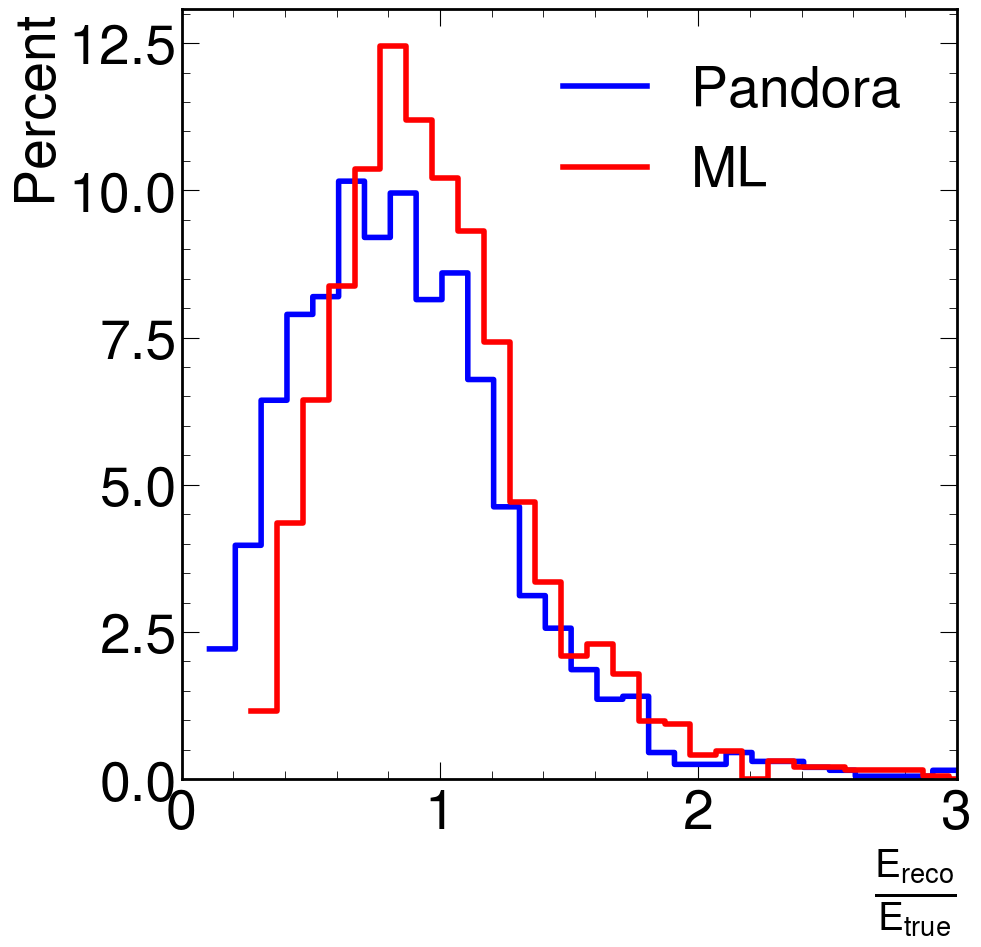

In [13]:
import seaborn as sns
fig = plt.figure()
ylabel = r"$\frac{E_{reco}}{ E_{true} }$"
plt.xlabel(ylabel, fontsize=40)
plt.ylabel("Percent", fontsize=40)
sns.histplot(e_over_true_pandora, binwidth=0.1, label="Pandora", stat="percent",  color="blue", element="step",linewidth=4,fill=False)
sns.histplot(e_over_true+(1-np.mean(e_over_true)), binwidth=0.1, label="ML", stat="percent", color="red", element="step",linewidth=4, fill=False)
plt.legend(fontsize=40, loc="upper right")
plt.tick_params(axis="both", which="major", labelsize=40)
plt.xlim([0,3])
# plt.yscale("log")

In [26]:
print(np.var(e_over_true)/np.mean(e_over_true))
print(np.var(e_over_true_pandora)/np.mean(e_over_true_pandora))
print(np.var(e_over_true)/np.mean(e_over_true))
print(np.var(e_over_true_pandora)/np.mean(e_over_true_pandora))

0.03465837
0.04042544


In [57]:
from src.utils.inference.inference_metrics import obtain_MPV_and_68
bins_per_binned_E = np.arange(0.9,1.2, 1e-3)
bins_per_binned_E_o = np.arange(0.9,1.2, 1e-3)
mean_predtotrue, var_predtotrue = obtain_MPV_and_68(
    e_over_true, bins_per_binned_E
)

In [58]:
mean_predtotrue_p, var_predtotrue_p = obtain_MPV_and_68(
    e_over_true_pandora, bins_per_binned_E_o
)
var_predtotrue_p

0.08053055423969689

In [59]:
var_predtotrue

0.08486118386589844

In [53]:
hist, bin_edges = np.histogram(e_over_true, bins=bins_per_binned_E, density=True)
    

(array([3., 0., 1., 0., 0., 2., 0., 2., 3., 0., 1., 2., 2., 0., 0., 2., 1.,
        0., 2., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 1., 1., 0., 0., 1., 0., 3., 3., 1., 0., 0., 0., 3., 2., 2., 1.,
        1., 1., 0., 4., 0., 3., 1., 0., 2., 1., 1., 1., 1., 1., 3., 3., 1.,
        1., 0., 1., 0., 0., 2., 1., 3., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 2., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 1., 1., 2., 2., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 2., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0.,
        0., 3., 0., 3., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 2.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 3., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 2., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 2., 1., 0., 2.,
        0., 

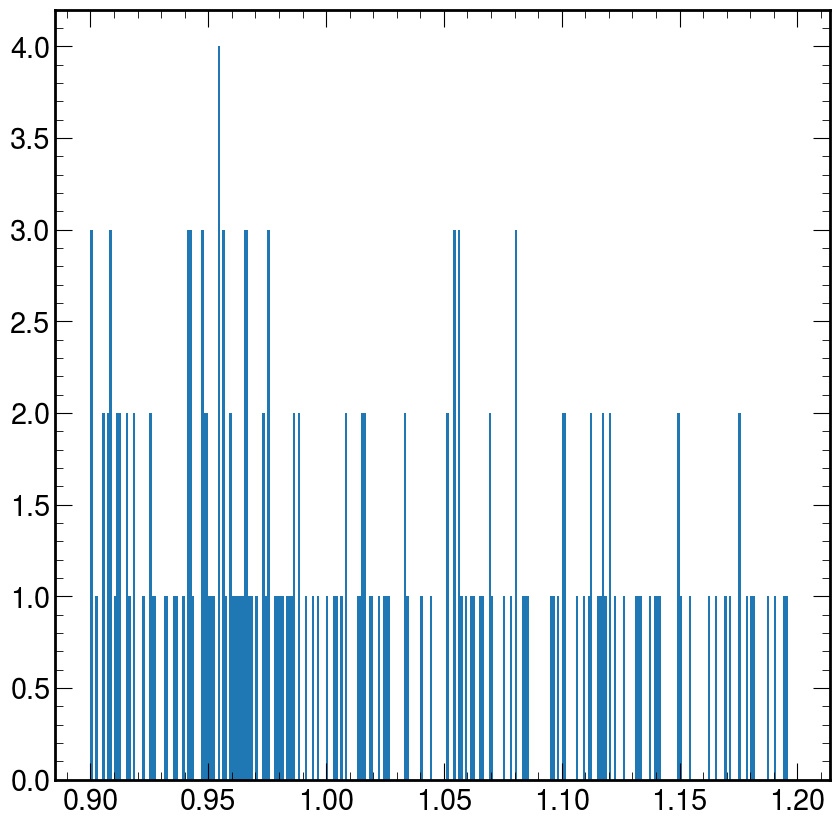

In [56]:
plt.hist(e_over_true, bins=bins_per_binned_E)

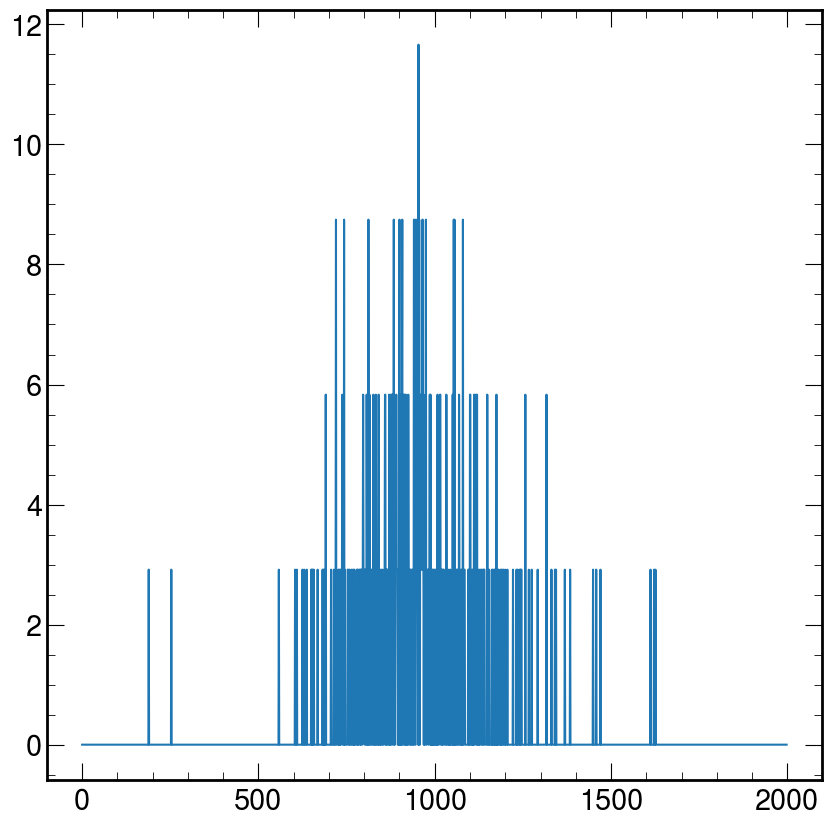

In [51]:
plt.plot(hist)

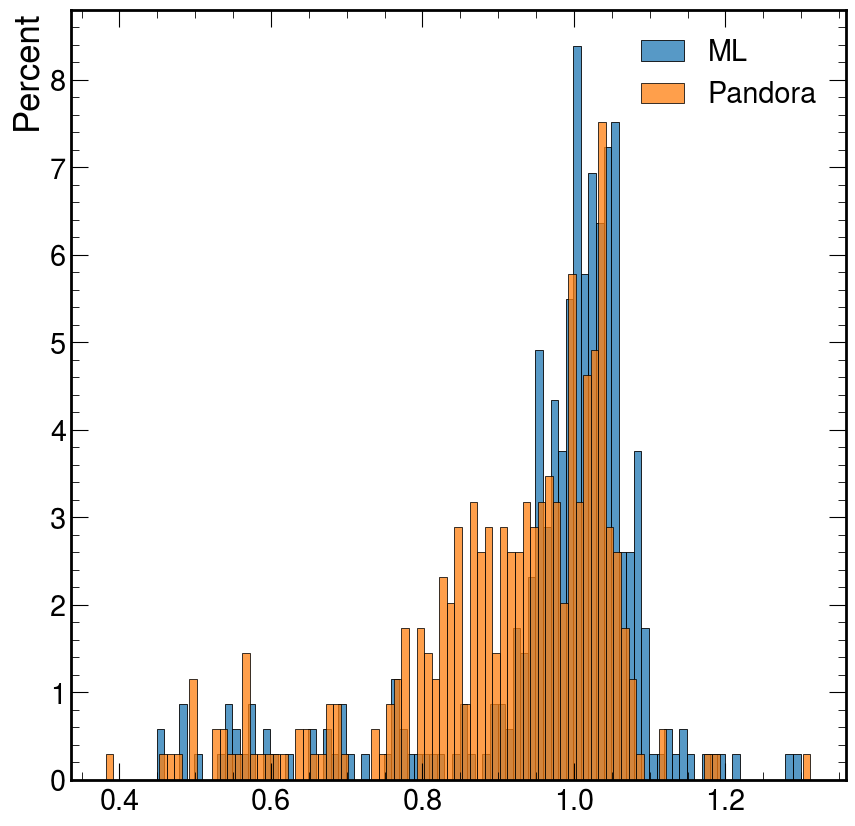

In [64]:
import seaborn as sns
sns.histplot(e_over_true, binwidth=1e-2, label="ML", stat="percent")
sns.histplot(e_over_true_pandora, binwidth=1e-2, label="Pandora", stat="percent")
plt.legend()

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pid,step,number_batch
3,5.486268,3.079285,3.006043,3.006043,8.517430,7.677358,0.0,2.0,1.0
8,4.558251,3.108215,2.578224,2.578224,2.751481,2.658482,0.0,2.0,2.0
5,2.040950,3.156852,2.527594,2.527594,12.608999,10.201756,0.0,2.0,3.0
7,4.668846,3.087199,2.300624,2.170259,11.603451,11.552114,0.0,2.0,3.0
1,3.429031,3.072261,2.949147,2.949147,3.255619,3.005584,0.0,3.0,2.0
10,5.548736,3.451010,3.000545,3.000545,2.666488,2.666488,0.0,3.0,2.0
3,3.849500,3.320569,3.205964,3.205964,3.922982,3.256427,0.0,4.0,0.0
7,3.724001,3.433685,3.019889,3.019889,4.005358,3.774453,0.0,4.0,0.0
2,3.037528,3.041048,2.884895,2.884895,5.625613,5.278989,0.0,4.0,2.0
11,4.590189,3.460725,3.257928,3.257928,3.933908,4.677097,0.0,4.0,2.0


In [41]:
dic = torch.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained/all_energies_10_15/mlpf/mlpf_all_energies_hgcal_v3/showers_df_evaluation/graphs_all/0_2_3.pt", map_location='cpu')

In [42]:
labels_pandora = dic["graph"].ndata["pandora_cluster"].long()

In [43]:
labels_pandora = dic["graph"].ndata["pandora_cluster"].long()
labels_pandora = labels_pandora+1
map_from = list(np.unique(labels_pandora))
cluster_id = map(lambda x: map_from.index(x), labels_pandora)
labels_pandora = torch.Tensor(list(cluster_id)).long()
print(np.unique(labels_pandora))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [58]:
betas  = torch.sigmoid(dic["graph"].ndata["beta"])
X  = dic["graph"].ndata["coords"]
clustering_mode = "dbscan"
if clustering_mode == "clustering_normal":
    clustering = get_clustering(betas,X)
elif clustering_mode == "dbscan":
    distance_scale = torch.min(torch.abs(torch.min(X,dim=0)[0] - torch.max(X,dim=0)[0]))/35
    print(distance_scale)
    #distance_scale = 0.1
    db = DBSCAN(eps=distance_scale, min_samples=10).fit(X)
    labels = db.labels_ +1
    labels = np.reshape(labels, (-1))
    labels = torch.Tensor(labels).long()

tensor(0.1618)


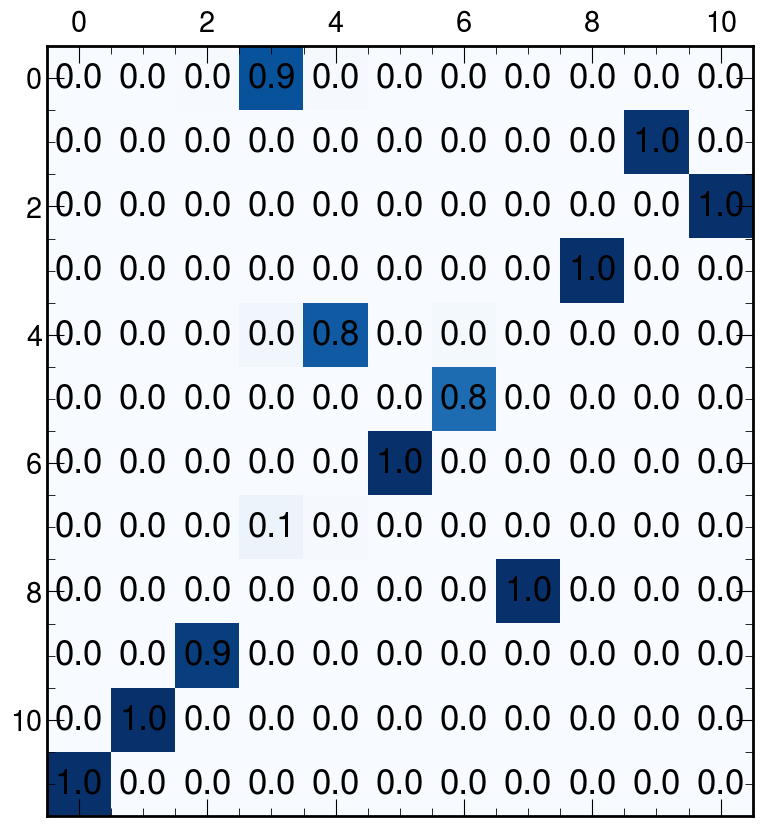

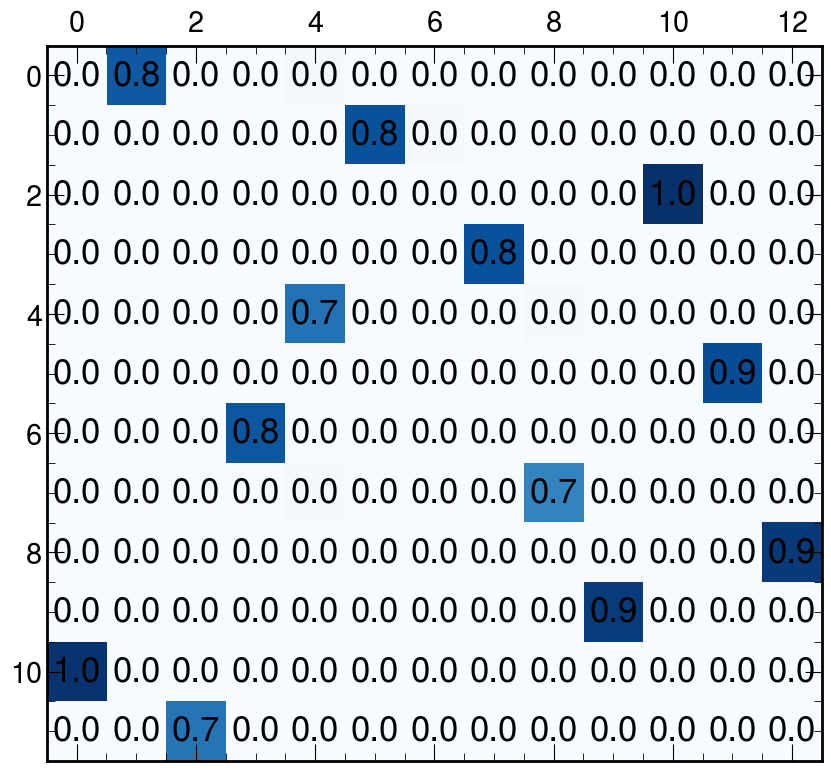

In [59]:
row_ind, col_ind, particle_ids, df = shower_matching(labels)
row_ind_pandora, col_ind_pandora, particle_ids_pandora, df_pandora = shower_matching(labels_pandora)

In [52]:
df_pandora

,true_showers_E,pred_showers_E,e_pred_and_truth,pid
0,35.050320,34.991173,32.861713,0.0
1,8.570908,6.815506,6.815506,0.0
2,2.236897,2.209092,2.209092,0.0
3,0.896664,0.518082,0.518082,0.0
4,13.633471,14.993949,12.492950,0.0
5,2.040950,2.527594,2.527594,0.0
6,20.770233,16.903244,16.903244,0.0
7,4.668846,2.300624,2.170259,0.0
8,32.127712,30.407360,30.407360,0.0
9,48.074810,51.992081,50.698128,0.0


In [53]:
df

,true_showers_E,pred_showers_E,e_pred_and_truth,pid
0,35.050320,40.717758,34.592445,0.0
1,8.570908,7.147790,7.147790,0.0
2,2.236897,2.237986,2.237986,0.0
3,0.896664,0.551366,0.551366,0.0
4,13.633471,13.596376,11.944524,0.0
5,2.040950,3.300786,3.156852,0.0
6,20.770233,17.436918,17.436918,0.0
7,4.668846,NaN,NaN,0.0
8,32.127712,34.555889,34.460503,0.0
9,48.074810,52.502625,51.106743,0.0


In [117]:
torch.unique(dic["graph"].ndata['particle_number'])

tensor([1., 2., 3., 4., 5., 6.])

In [48]:
print(scatter_add(torch.ones_like(dic["graph"].ndata['particle_number']),dic["graph"].ndata['particle_number'].to(torch.int64) ))
print(scatter_add(dic["graph"].ndata['e_hits'].view(-1),dic["graph"].ndata['particle_number'].to(torch.int64) ))

tensor([  0., 813., 271.,  40.,  40., 422.,  30., 304.,  56., 282., 258.,  52.,
         57.])
tensor([ 0.0000, 36.9096,  7.3356,  2.2380,  0.5514, 14.0435,  3.1569, 17.4369,
         3.0872, 34.4605, 53.0273,  1.5740,  2.6726])


In [101]:
mask = dic["graph"].ndata['particle_number']==4
dic["graph"].ndata['e_hits'].view(-1)[mask]

tensor([0.0214, 0.1107])

In [7]:
def shower_matching(labels):
    from src.layers.inference_oc import obtain_intersection_matrix, obtain_union_matrix
    particle_ids = torch.unique(dic["graph"].ndata['particle_number'])
    iou_threshold = 0.05
    shower_p_unique = torch.unique(labels)
    if torch.sum(labels == 0) == 0:
            shower_p_unique = torch.cat(
                (
                    shower_p_unique.view(-1),
                    torch.Tensor([0]).to(shower_p_unique.device).view(-1),
                ),
                dim=0,
            )
    e_hits = dic["graph"].ndata['e_hits'].view(-1)
    i_m, i_m_w = obtain_intersection_matrix(shower_p_unique,particle_ids, labels, dic, e_hits)
    u_m = obtain_union_matrix(shower_p_unique,particle_ids, labels, dic)
    iou_matrix = i_m / u_m
    iou_matrix_num = (
            torch.transpose(iou_matrix[1:, :], 1, 0).clone().detach().cpu().numpy()
        )
    iou_matrix_num[iou_matrix_num < iou_threshold] = 0
    row_ind, col_ind = linear_sum_assignment(-iou_matrix_num)
    mask_matching_matrix = iou_matrix_num[row_ind, col_ind] > 0
    row_ind = row_ind[mask_matching_matrix]
    col_ind = col_ind[mask_matching_matrix]
    plot_iou_matrix(iou_matrix,'')
    e_pred_showers = scatter_add(dic["graph"].ndata['e_hits'].view(-1), labels)
    pred_showers = shower_p_unique
    true_showers = particle_ids
    max_num_showers = torch.max(torch.Tensor([len(pred_showers), len(true_showers)]))

    # Add true showers (matched and unmatched)
    energy_t = dic["part_true"][:,3]
    pid = dic["part_true"][:,-2]
    index_matches = col_ind+1
    matched_es = torch.zeros_like(energy_t)*torch.nan
    matched_es[row_ind] = e_pred_showers[index_matches]
    intersection_E = torch.zeros_like(energy_t)*torch.nan
    ie_e = obtain_intersection_values(i_m_w,row_ind, col_ind )
    intersection_E[row_ind] = ie_e
    ## showers that are not in the true showers:
    pred_showers[index_matches] = -1
    mask = pred_showers != -1
    fake_showers_e = e_pred_showers[mask]
    fake_showers_showers_e_truw  = torch.zeros((fake_showers_e.shape[0]))*torch.nan
    energy_t = torch.cat((energy_t, fake_showers_showers_e_truw), dim=0)
    pid_t = torch.cat((pid, fake_showers_showers_e_truw), dim=0)
    e_pred = torch.cat((matched_es,fake_showers_e),dim=0) 
    e_pred_t = torch.cat((intersection_E, torch.zeros_like(fake_showers_e)*torch.nan), dim=0)
    d = {'true_showers_E': energy_t, 'pred_showers_E':e_pred, 'e_pred_and_truth':e_pred_t, "pid":pid_t}
    df = pd.DataFrame(data=d)
    total_showers = len(df["pred_showers_E"].values)
    number_of_non_reconstructed_showers = np.sum(np.isnan(df["pred_showers_E"].values))
    (total_showers-number_of_non_reconstructed_showers)/total_showers
    return row_ind, col_ind, particle_ids, df

In [21]:
particle_label_true = dic["graph"].ndata['particle_number']
model_label = labels

In [24]:
label_matched = torch.ones_like(model_label)*-2
for number_i in range(0, len(row_ind)):
    mask_i = model_label == (col_ind[number_i]+1)
    label_matched[mask_i] = 1*(particle_label_true[mask_i]==particle_ids[row_ind[number_i]]) 

label_matched_pandora = torch.ones_like(model_label)*-2
for number_i in range(0, len(row_ind_pandora)):
    mask_i = labels_pandora == (col_ind_pandora[number_i]+1)
    label_matched_pandora[mask_i] = 1*(particle_label_true[mask_i]==particle_ids[row_ind_pandora[number_i]])

store_image(label=False, cluster=False, true_false=True)
store_image(label=False, cluster=False, pandora=True,  true_false=True)
 

In [66]:
# fig, ax = plt.subplots()
# ax.matshow(intersection_matrix_w, cmap=plt.cm.Blues)
# for i in range(0,intersection_matrix_w.shape[1]):
#     for j in range(0,intersection_matrix_w.shape[0]):
#         c = np.round(intersection_matrix_w[j,i].numpy(),2)
#         ax.text(i, j, str(c), va='center', ha='center')

In [169]:
torch.sum(label_matched_pandora==1)

tensor(1695)

In [23]:
from src.logger.plotting_tools import shuffle_truth_colors

In [93]:
from src.logger.plotting_tools import shuffle_truth_colors
label_print = dic["graph"].ndata['particle_number'].view(-1).clone()
mask = label_print==4
tidx = label_print.view(-1)
features =  dic["graph"].ndata["e_hits"]
pos_hits =dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
rdst = np.random.RandomState(1234567890)  # all the same
#shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
# hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [145]:

store_image(label=False, cluster=False, pandora=True)

In [ ]:
store_image(label=True, cluster=False)

In [49]:
store_image(label=True, cluster=False)
store_image(label = False, cluster=False)
store_image(label=False, cluster=True)
store_image(label = True, cluster=True)
store_image(label = True, true_false=True)

In [10]:
def plot_iou_matrix(iou_matrix, image_path):
    iou_matrix = torch.transpose(iou_matrix[1:, :], 1, 0)
    fig, ax = plt.subplots()
    iou_matrix = iou_matrix.detach().cpu().numpy()
    ax.matshow(iou_matrix, cmap=plt.cm.Blues)
    for i in range(0, iou_matrix.shape[1]):
        for j in range(0, iou_matrix.shape[0]):
            c = np.round(iou_matrix[j, i], 1)
            ax.text(i, j, str(c), va="center", ha="center")

In [11]:
def store_image(label=False, cluster = False, pandora = False, true_false=False):
    if label:
        tidx = np.reshape(labels, (-1,1)) 
    elif pandora:
        if true_false:
            tidx = np.reshape(label_matched_pandora, (-1,1)) 
        else:
            tidx = np.reshape(labels_pandora, (-1,1))
    elif true_false:
        tidx = np.reshape(label_matched, (-1,1)) 
    else:
        tidx = dic["graph"].ndata['particle_number'].view(-1,1)
    features =  torch.log(dic["graph"].ndata["e_hits"])+10
    pos_hits =dic["graph"].ndata["pos_hits_xyz"]
    if cluster:
        pos_hits = X
    data = {
                "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
                "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
                "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
                "tIdx": tidx,
                "features": features.view(-1, 1).detach().cpu().numpy(),
            }
    hoverdict = {}
    # if hoverfeat is not None:
    #     for j in range(hoverfeat.shape[1]):
    #         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
    #     data.update(hoverdict)

    # if nidx is not None:
    #     data.update({"av_same": av_same})

    df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
    )
    df["orig_tIdx"] = df["tIdx"]
    rdst = np.random.RandomState(1234567890)  # all the same
    #shuffle_truth_colors(df, "tIdx", rdst)

    # hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
    # if nidx is not None:
    #     hover_data.append("av_same")
    fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size="features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
    )
    fig.update_traces(marker=dict(line=dict(width=0)))
    if pandora and true_false:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label_true_false.html"
    elif true_false:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label__true_false.html"
    elif label and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label.html"
    elif pandora and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label.html"
    elif label and cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_cluster.html"
    elif not label and  cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_cluster.html"
    else:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label.html"
    fig.write_html(path)